INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.11s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.01s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.08s). [brian2.stateupdaters.base.method_choice]


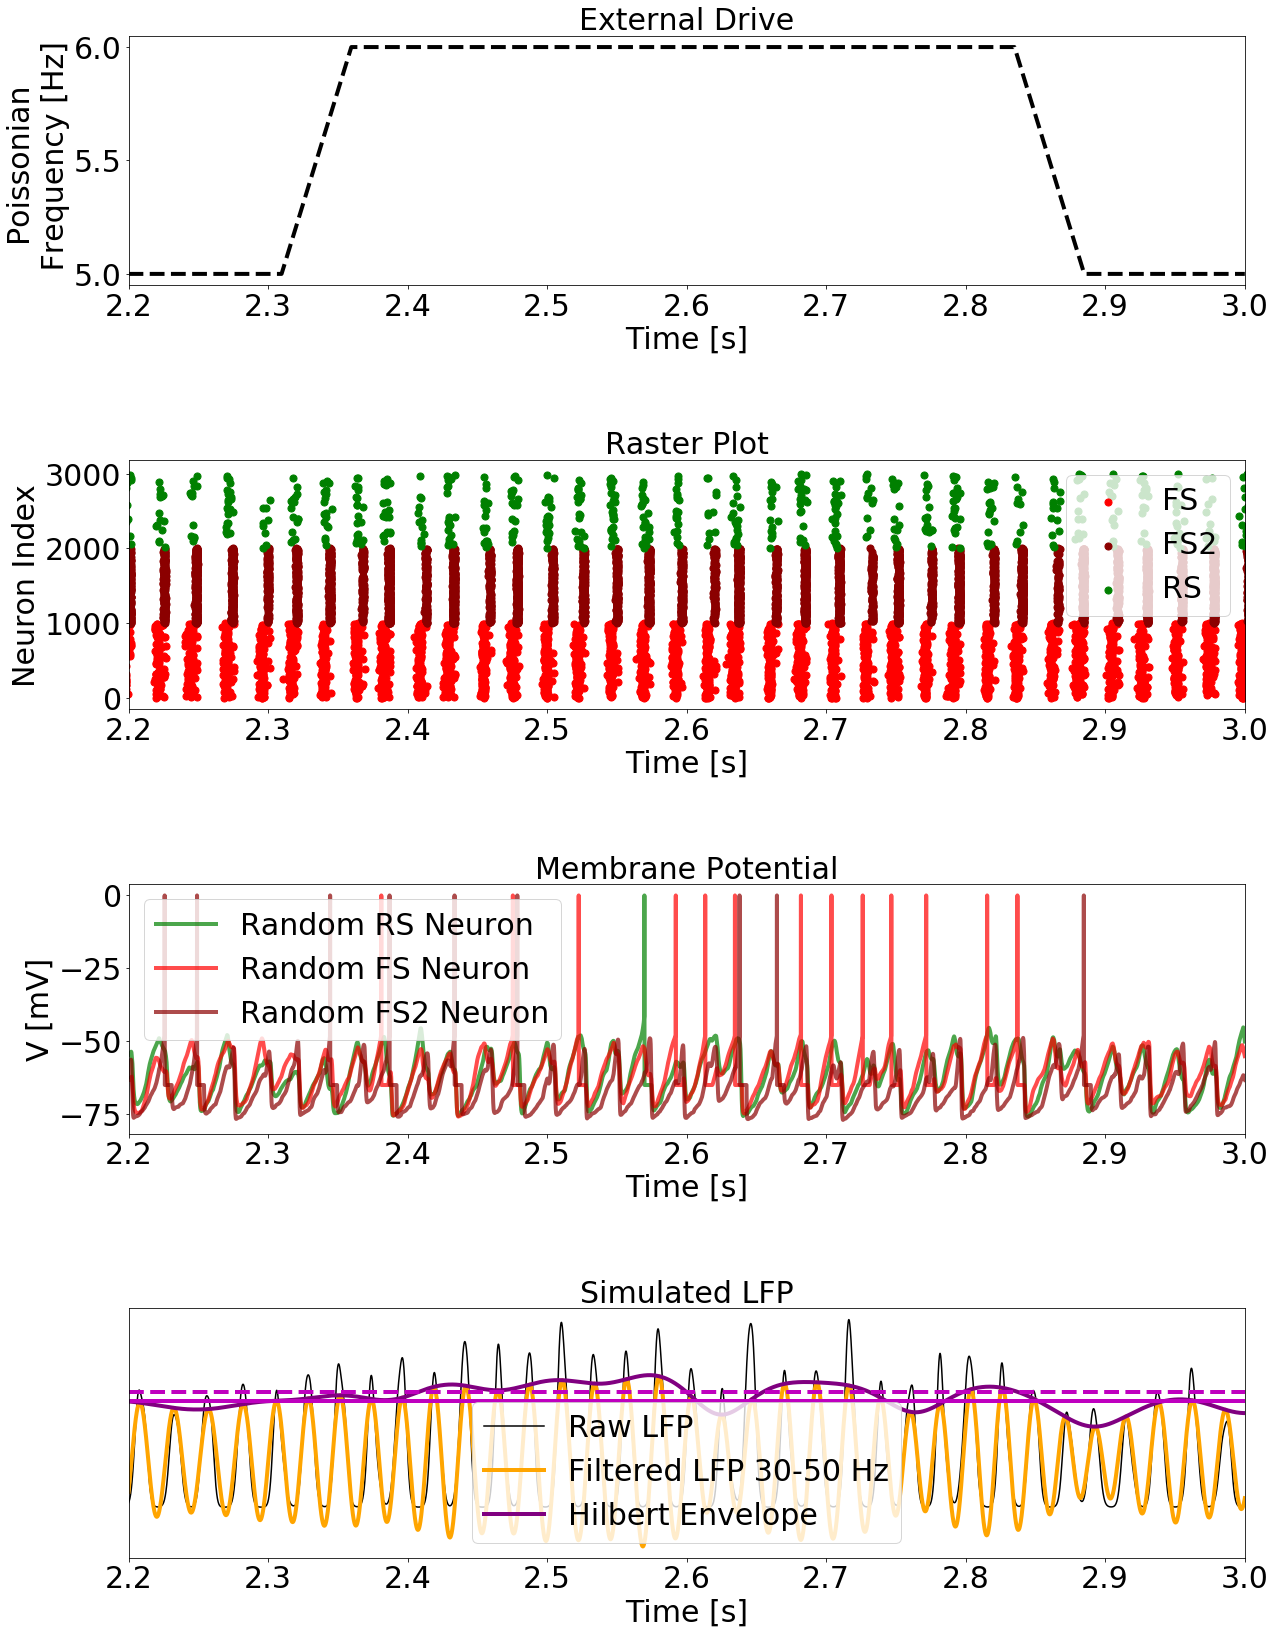

In [1]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.03 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.15  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5*nS #(FS2->FS)

Gee_r=1*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5.*ms; tauE_r= 5.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=5*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2.png")
plt.show()





INFO       No numerical integration method specified for group 'neurongroup_4', using method 'euler' (took 0.01s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_5', using method 'euler' (took 0.01s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_6', using method 'euler' (took 0.01s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]


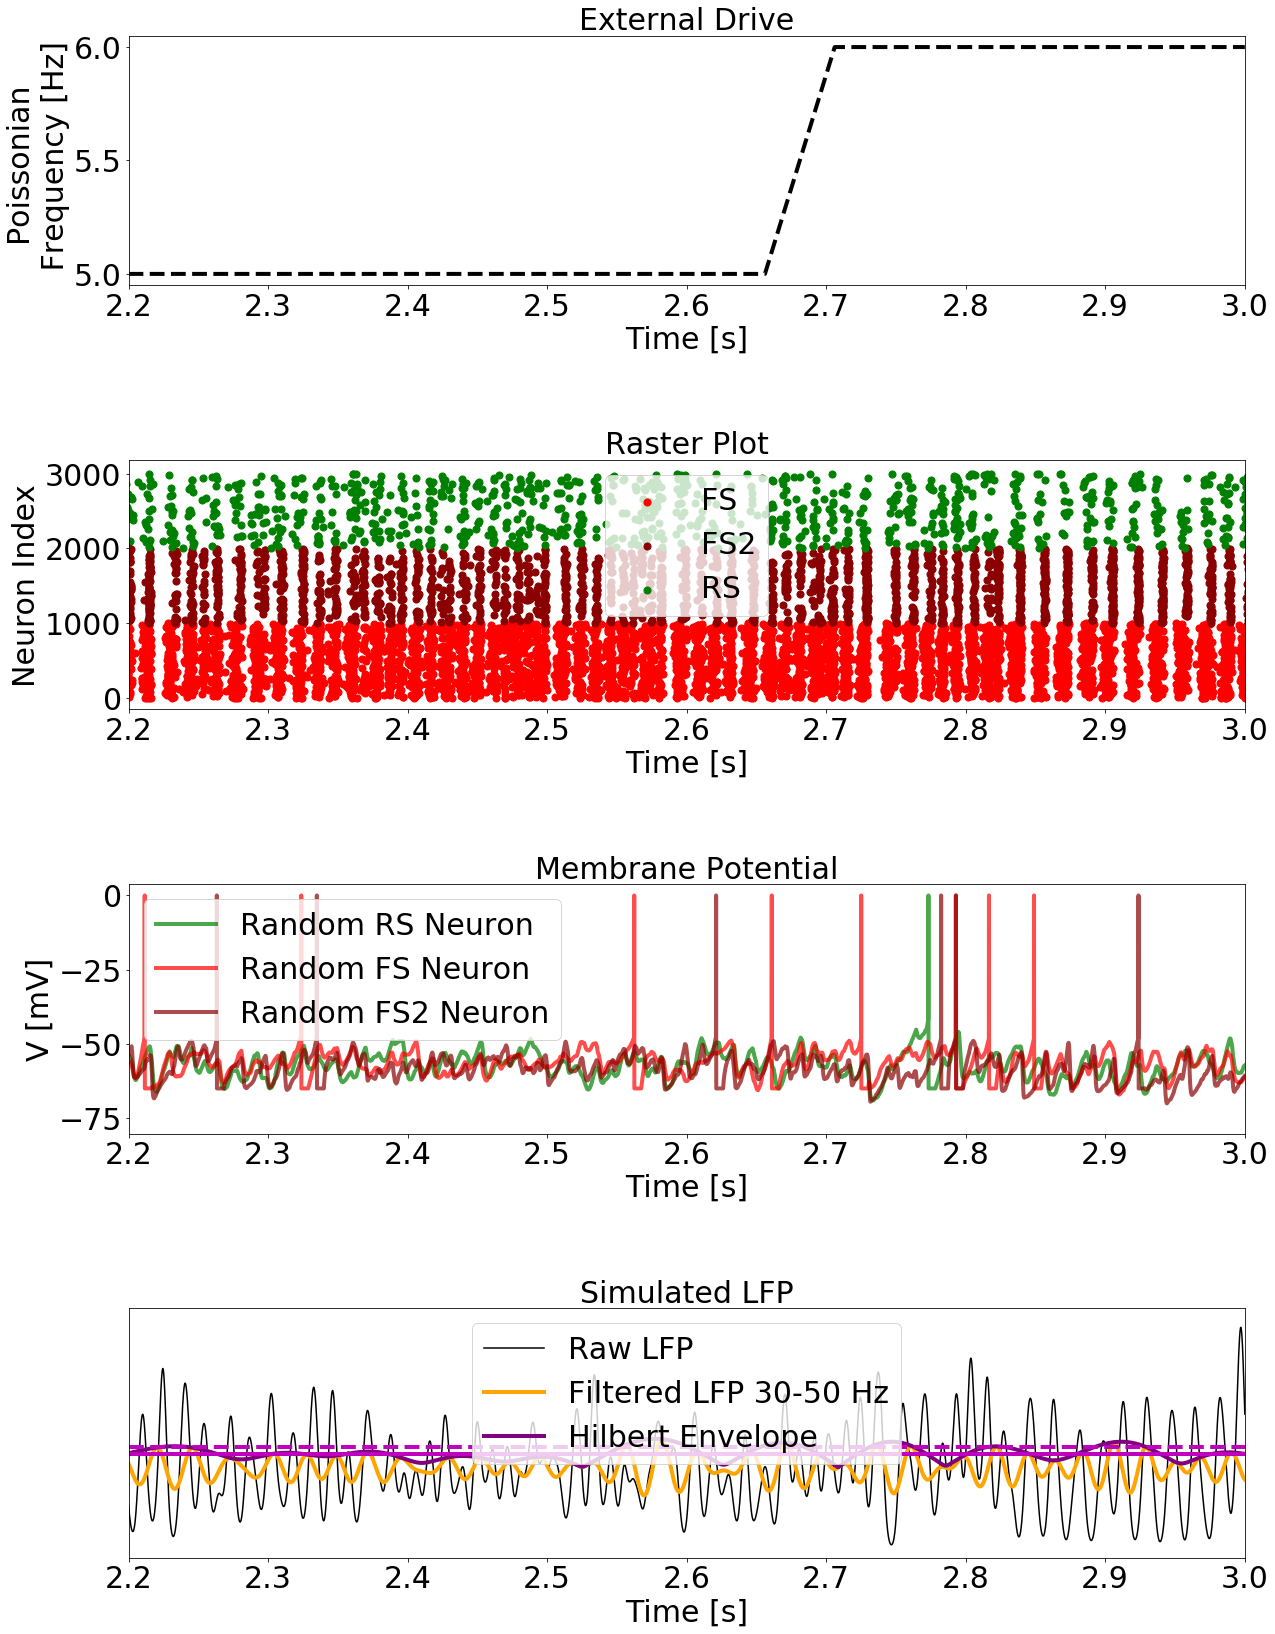

In [2]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.04 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.15  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5*nS #(FS2->FS)

Gee_r=1*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5.*ms; tauE_r= 5.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=5*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-2.png")
plt.show()





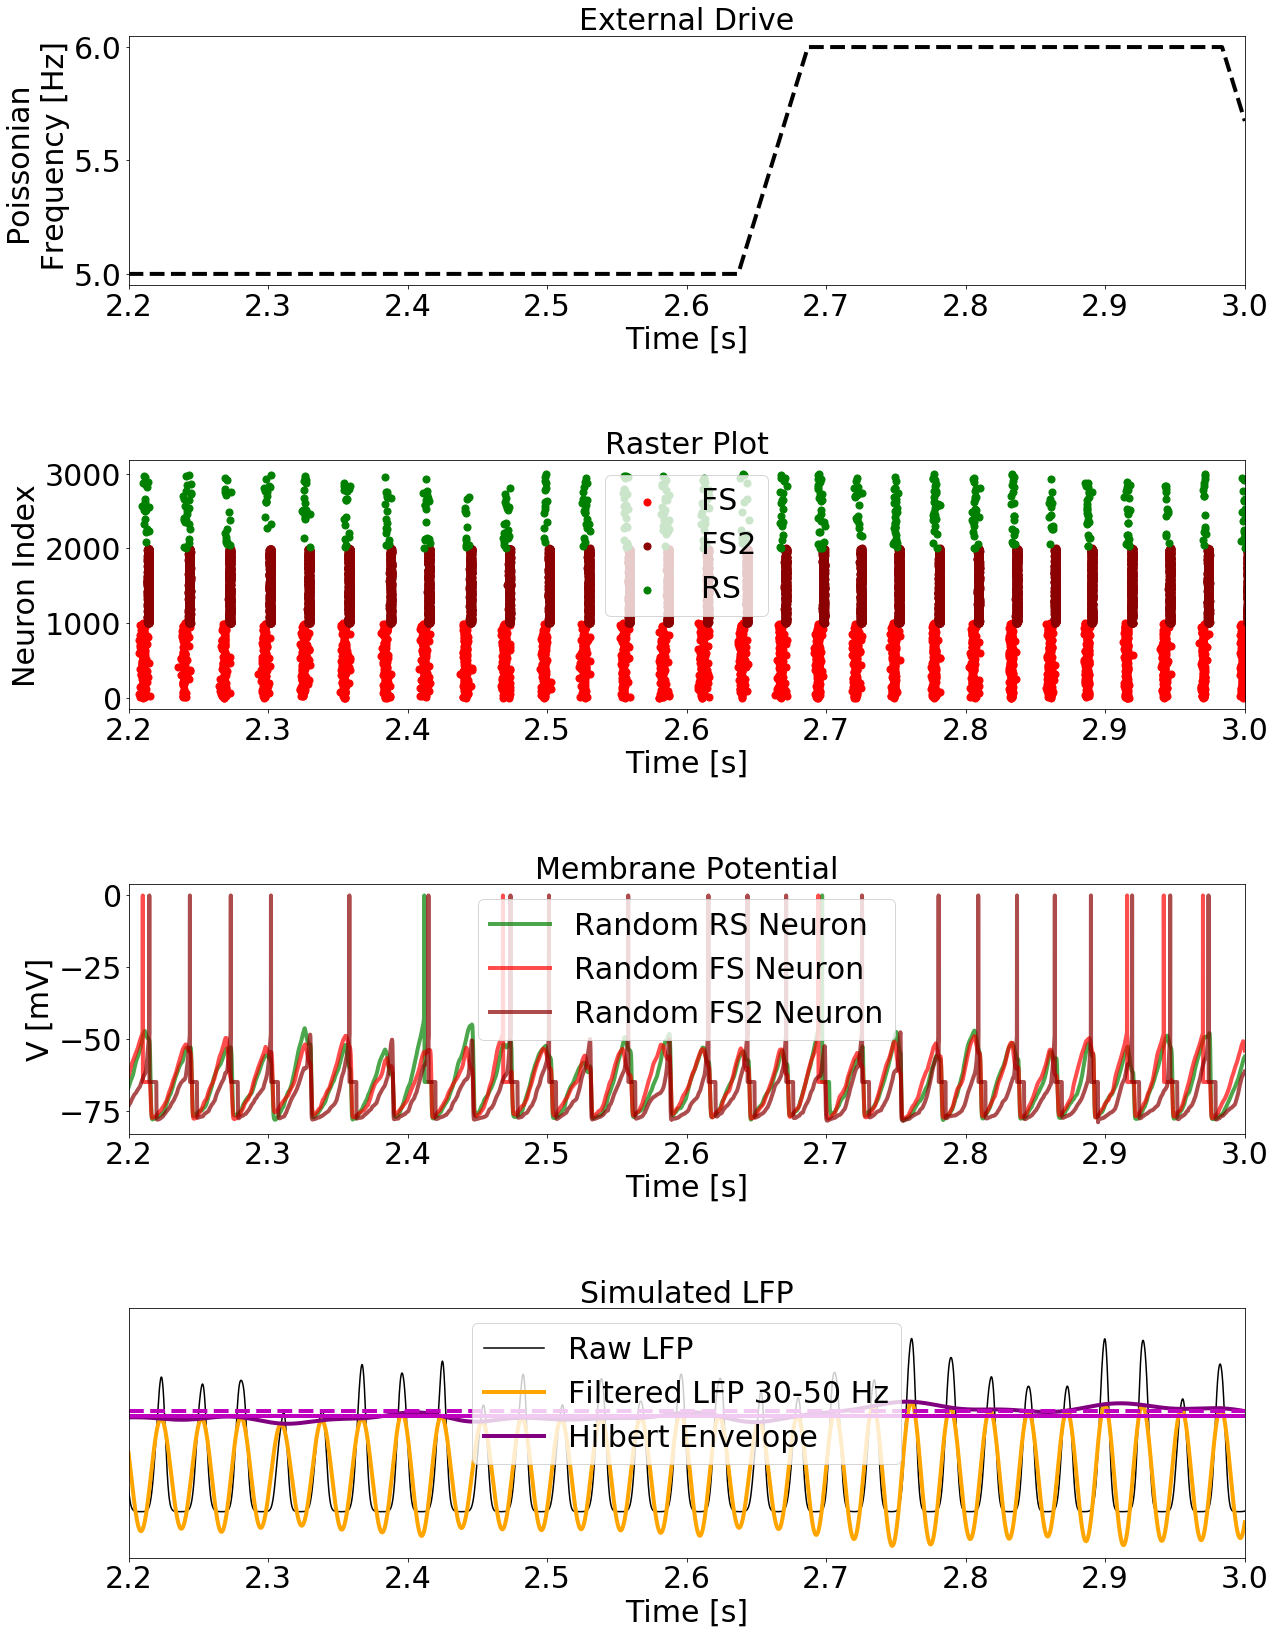

In [3]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.02 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.15  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5*nS #(FS2->FS)

Gee_r=1*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5.*ms; tauE_r= 5.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=5*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-3.png")
plt.show()





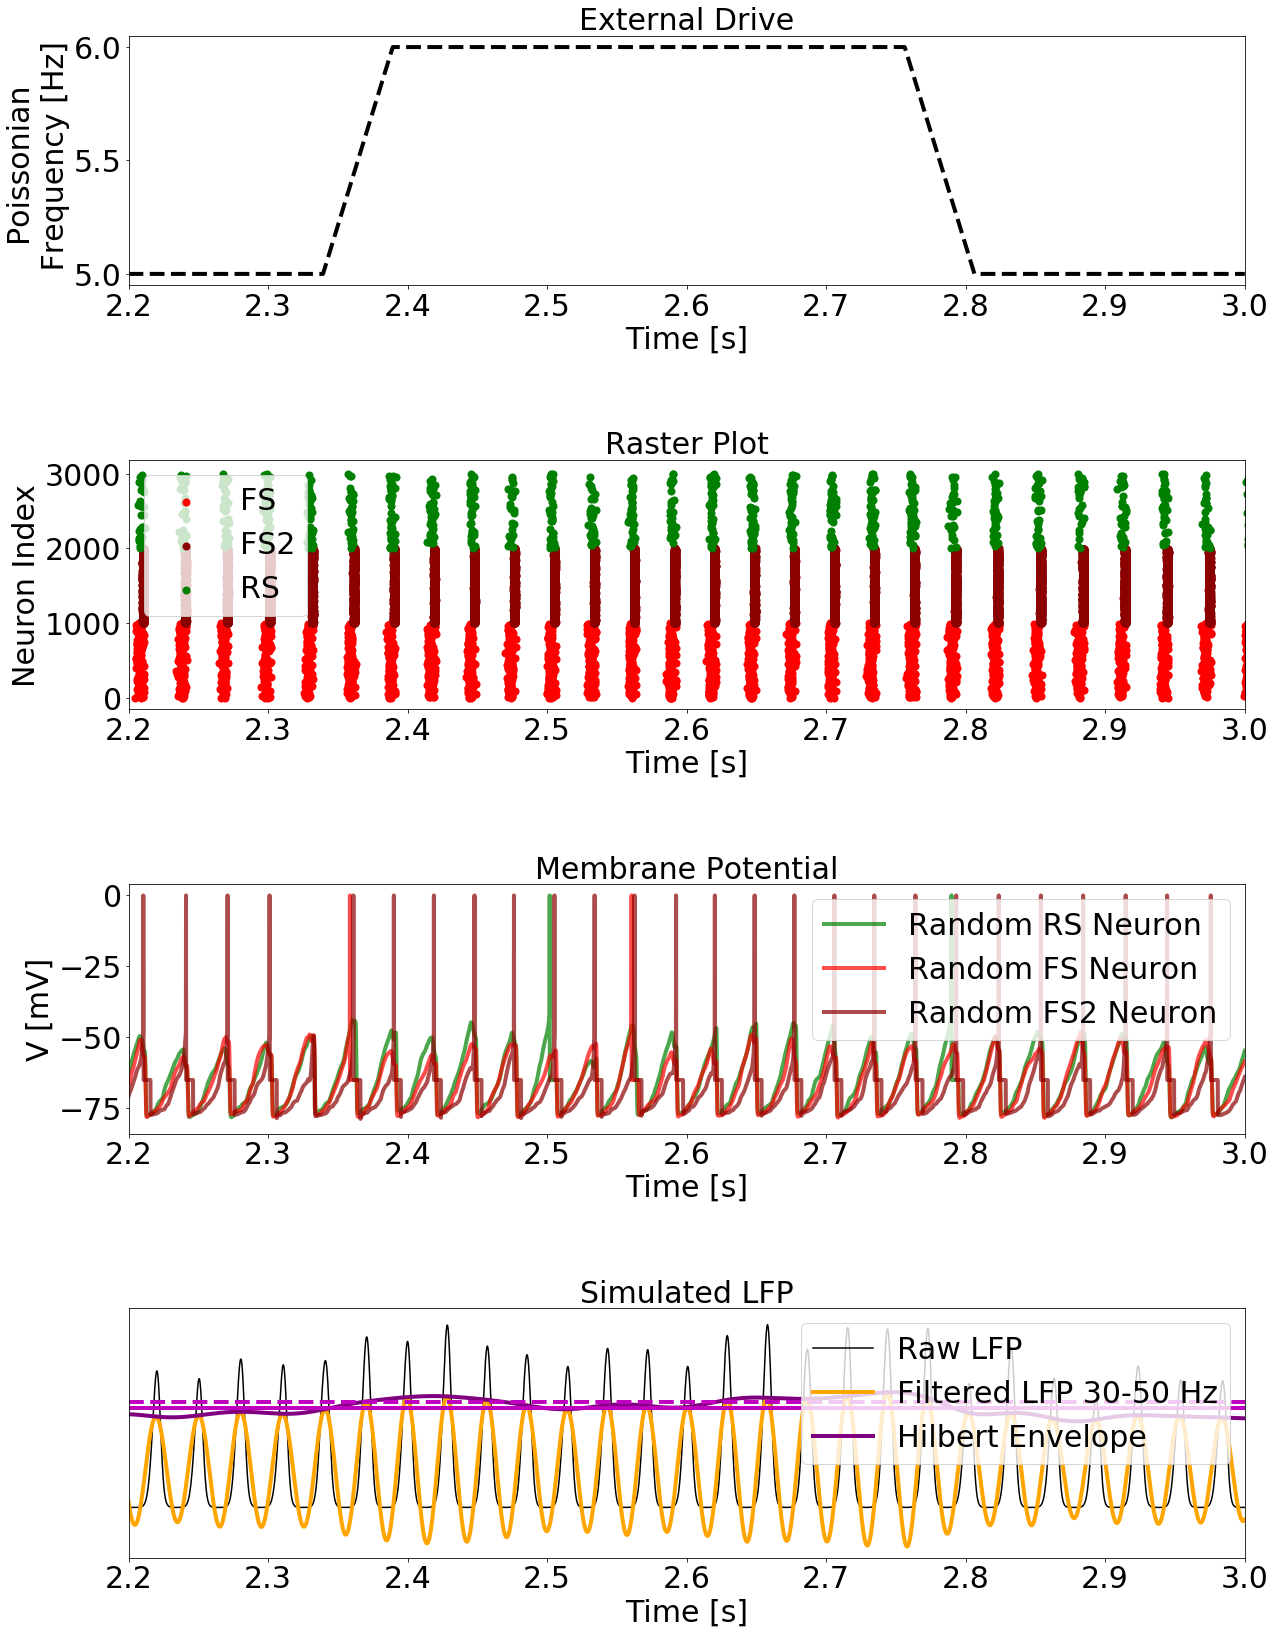

In [4]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.03 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.17  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5*nS #(FS2->FS)

Gee_r=1*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5.*ms; tauE_r= 5.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=5*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-4.png")
plt.show()





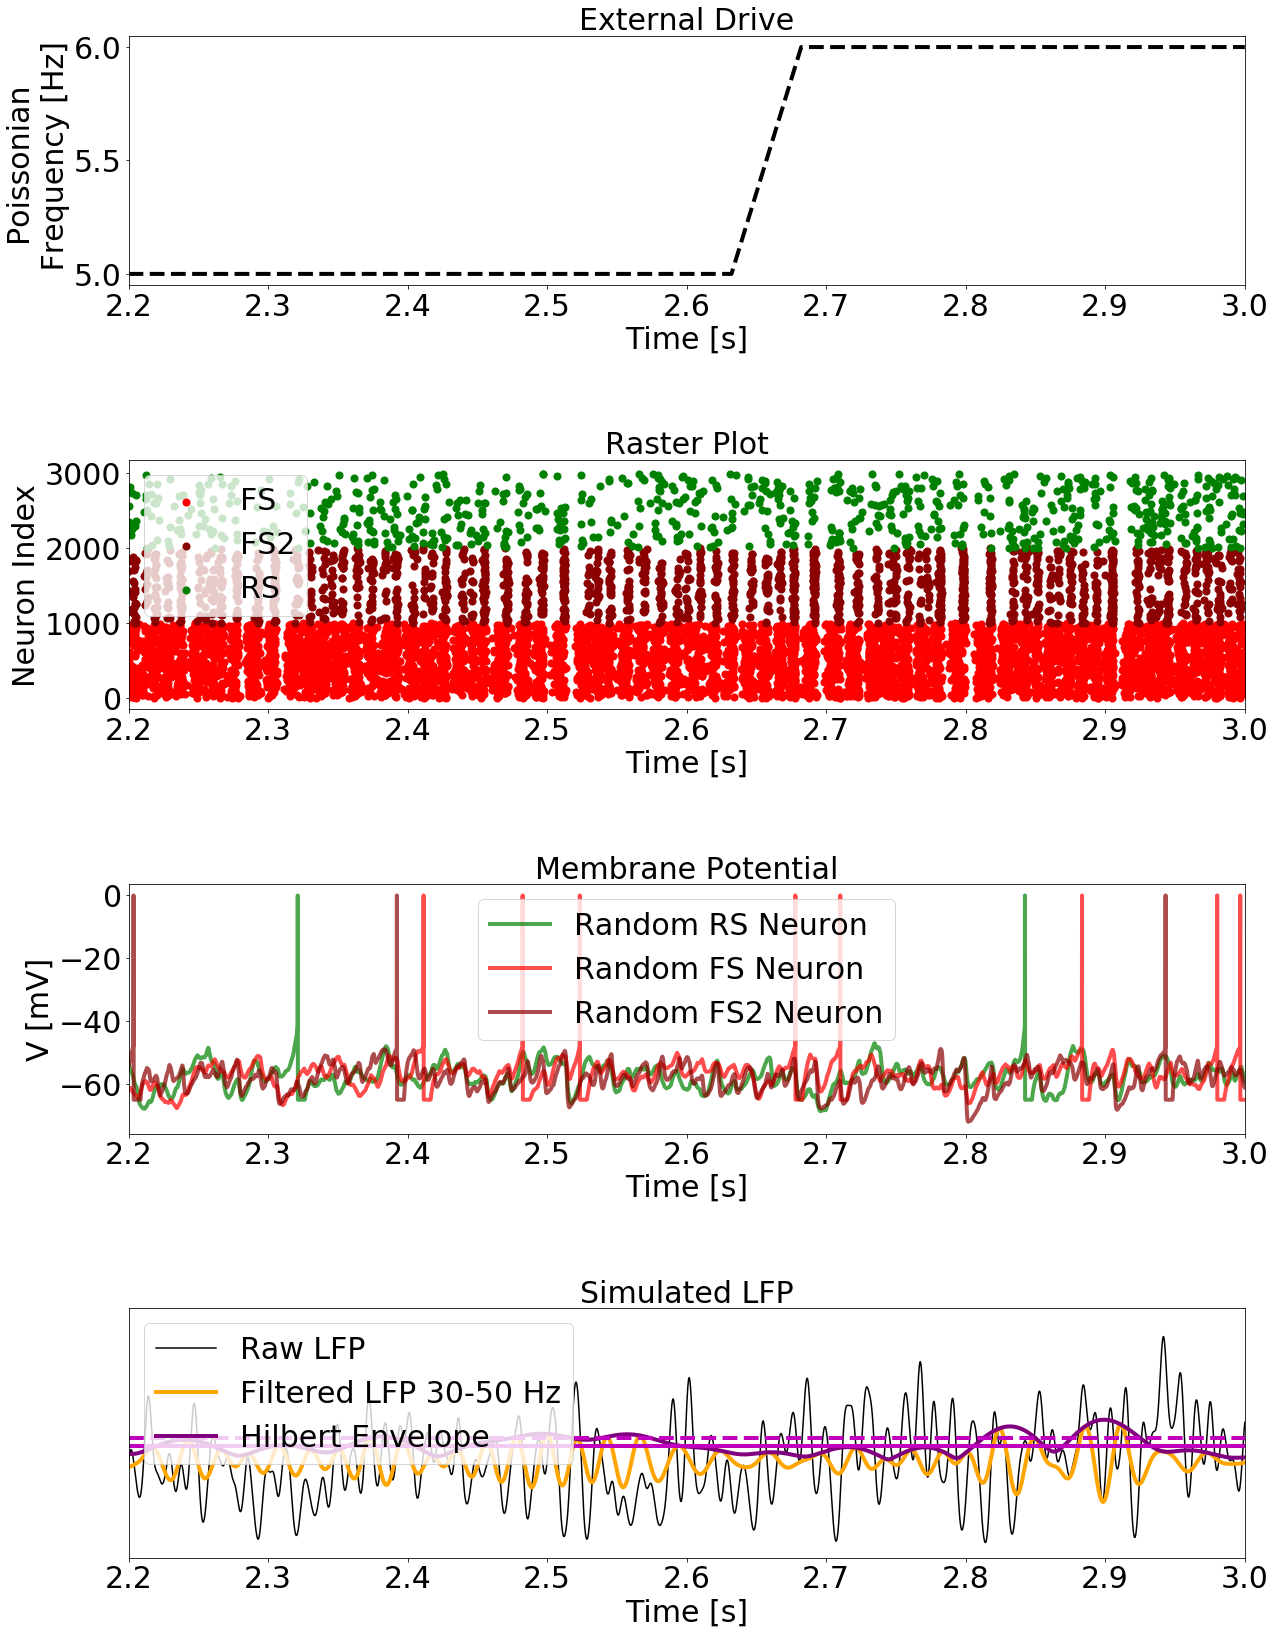

In [5]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.03 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.12  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5*nS #(FS2->FS)

Gee_r=1*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5.*ms; tauE_r= 5.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=5*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-5.png")
plt.show()





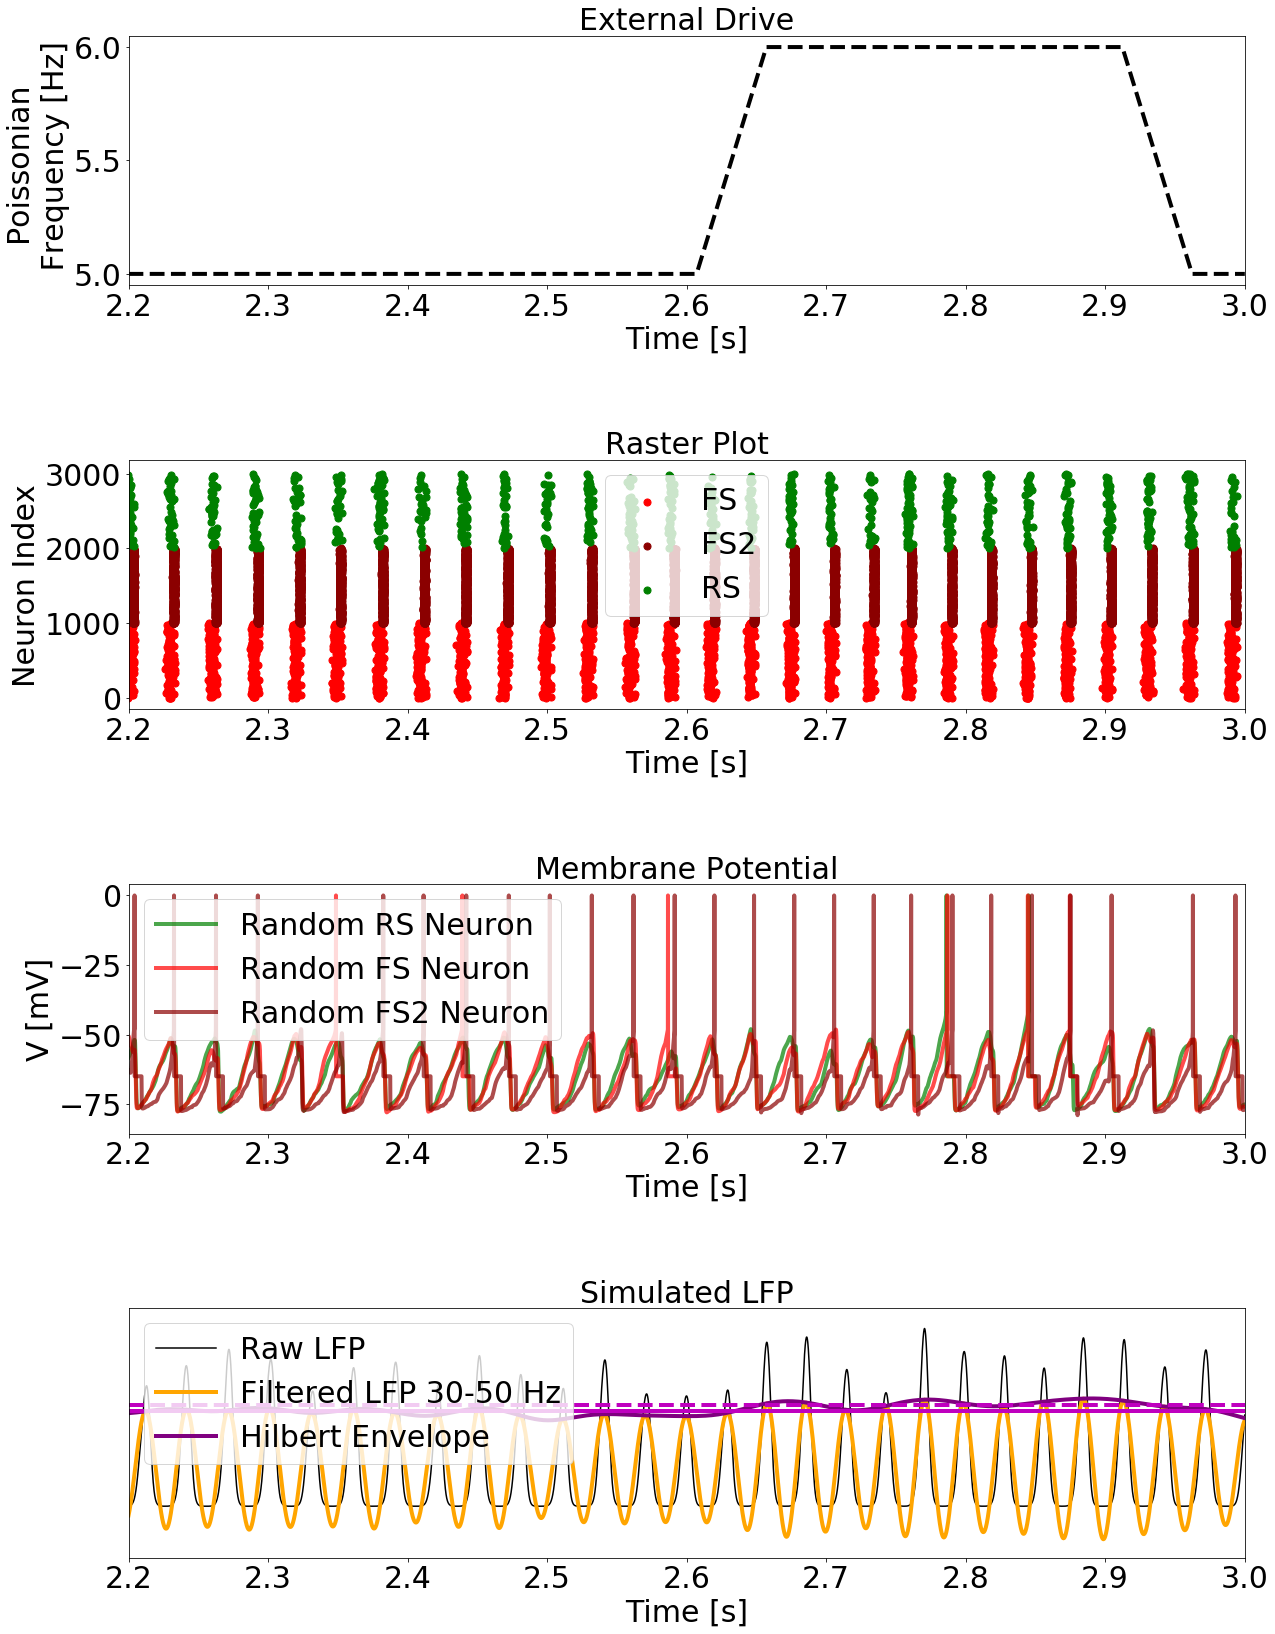

In [6]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.04 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.17  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5*nS #(FS2->FS)

Gee_r=1*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5.*ms; tauE_r= 5.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=5*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-6.png")
plt.show()





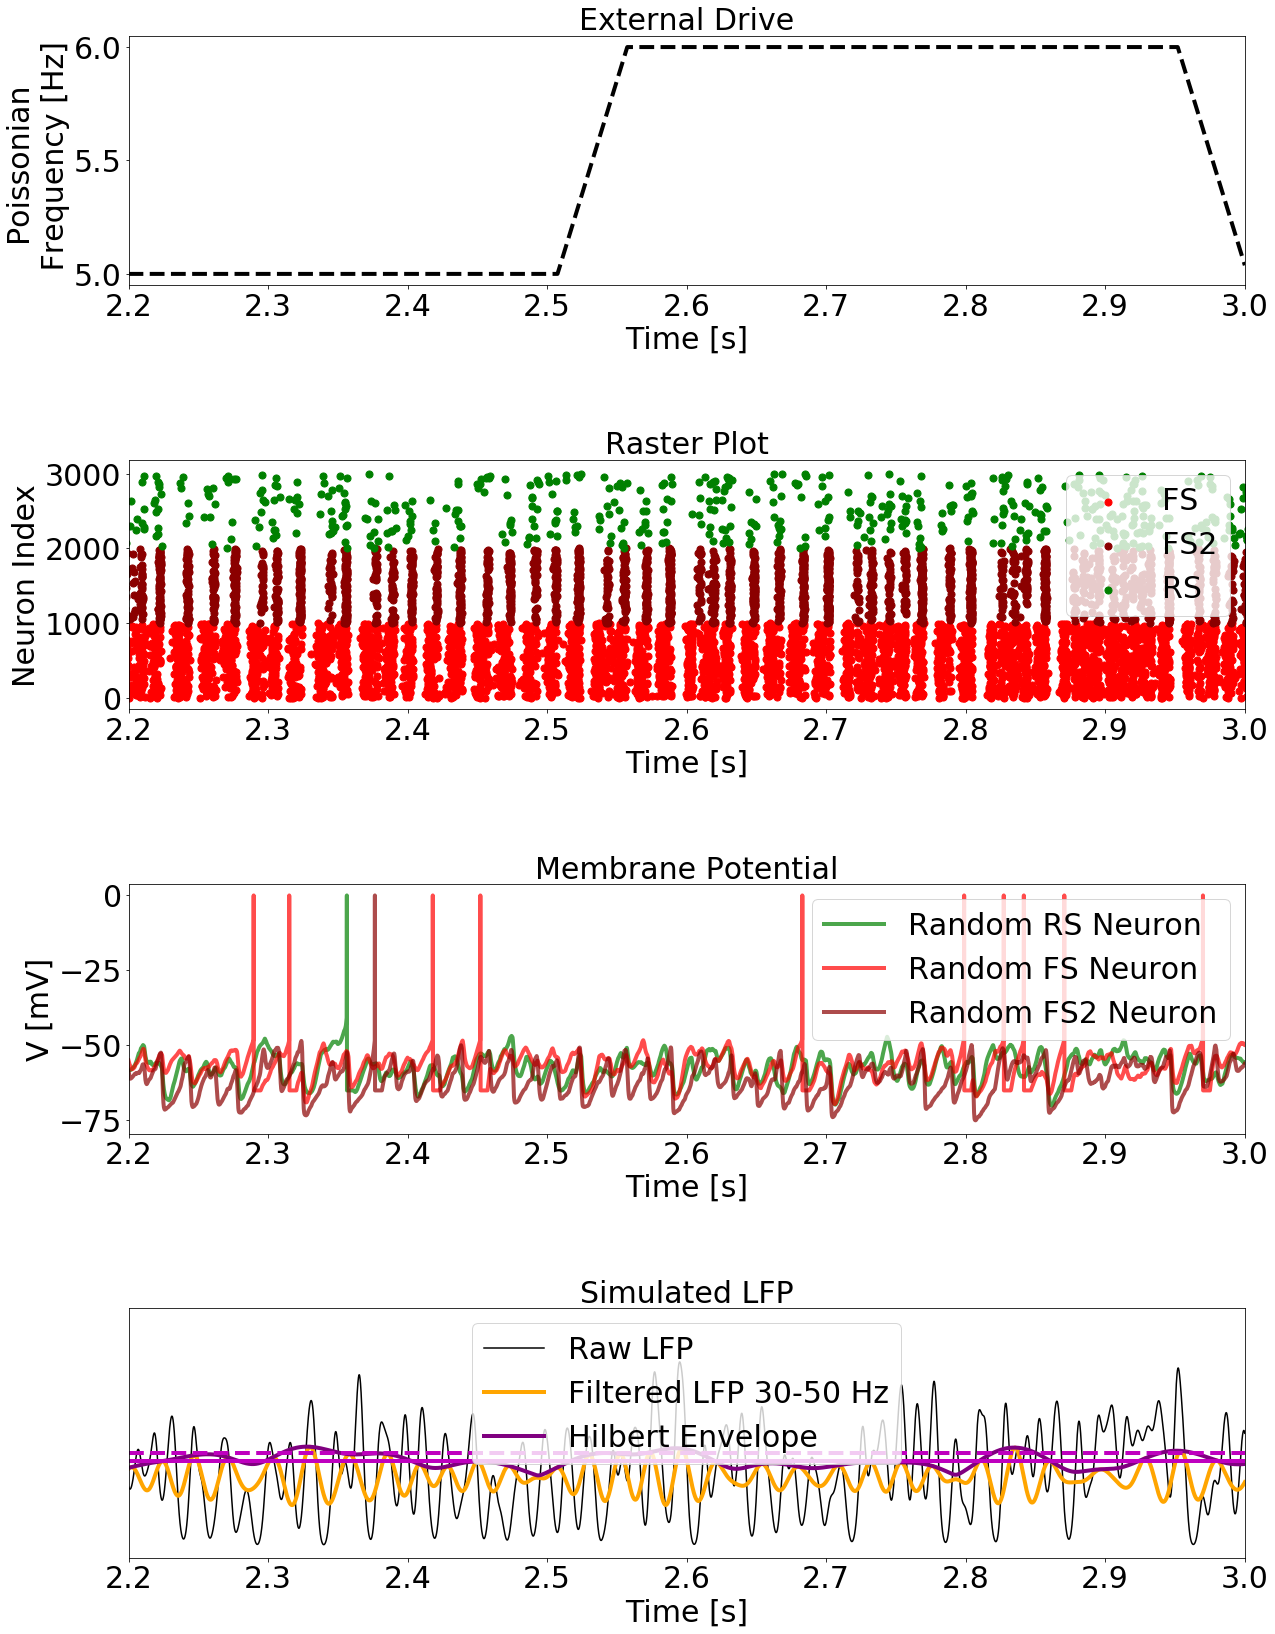

In [7]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.02 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.12  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5*nS #(FS2->FS)

Gee_r=1*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5.*ms; tauE_r= 5.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=5*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-7.png")
plt.show()





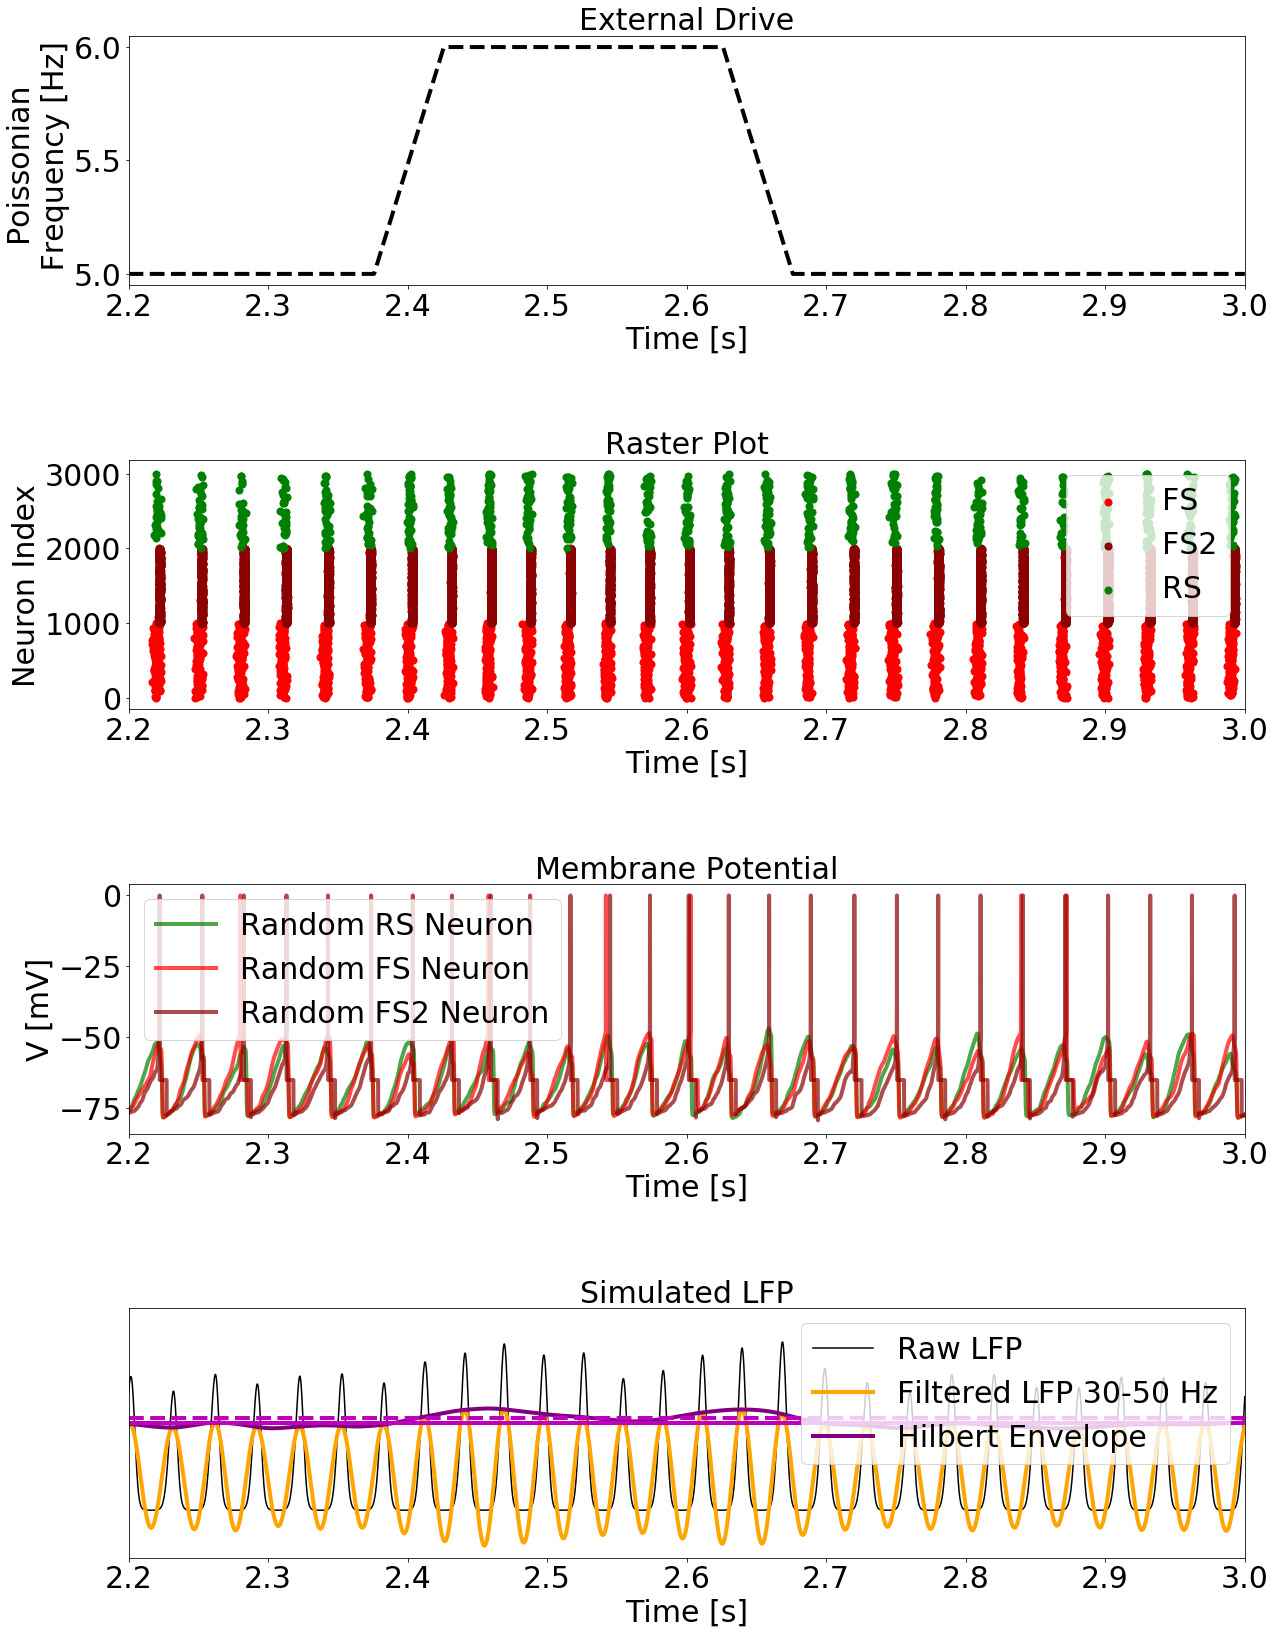

In [8]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.02 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.17  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5*nS #(FS2->FS)

Gee_r=1*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5.*ms; tauE_r= 5.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=5*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-8.png")
plt.show()





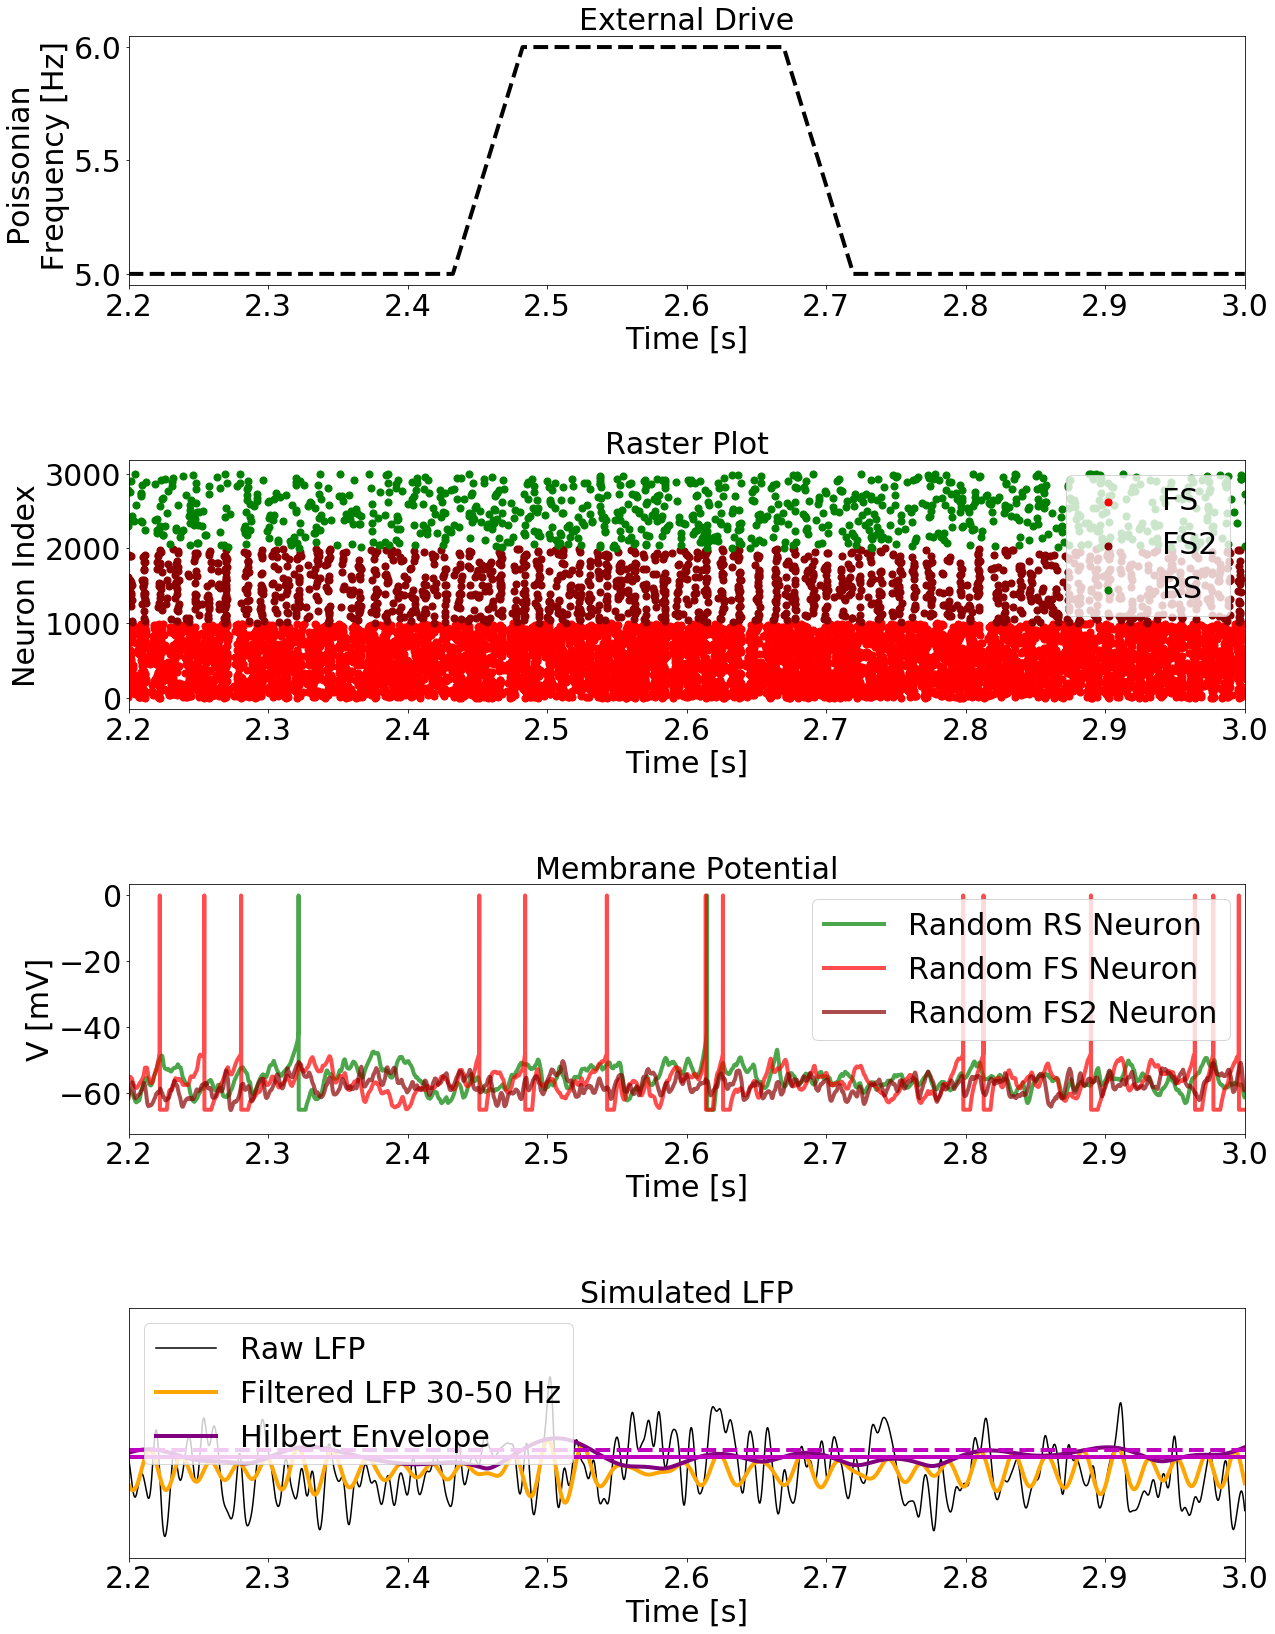

In [9]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.04 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.12  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5*nS #(FS2->FS)

Gee_r=1*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5.*ms; tauE_r= 5.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=5*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-9.png")
plt.show()





INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.13s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.01s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]


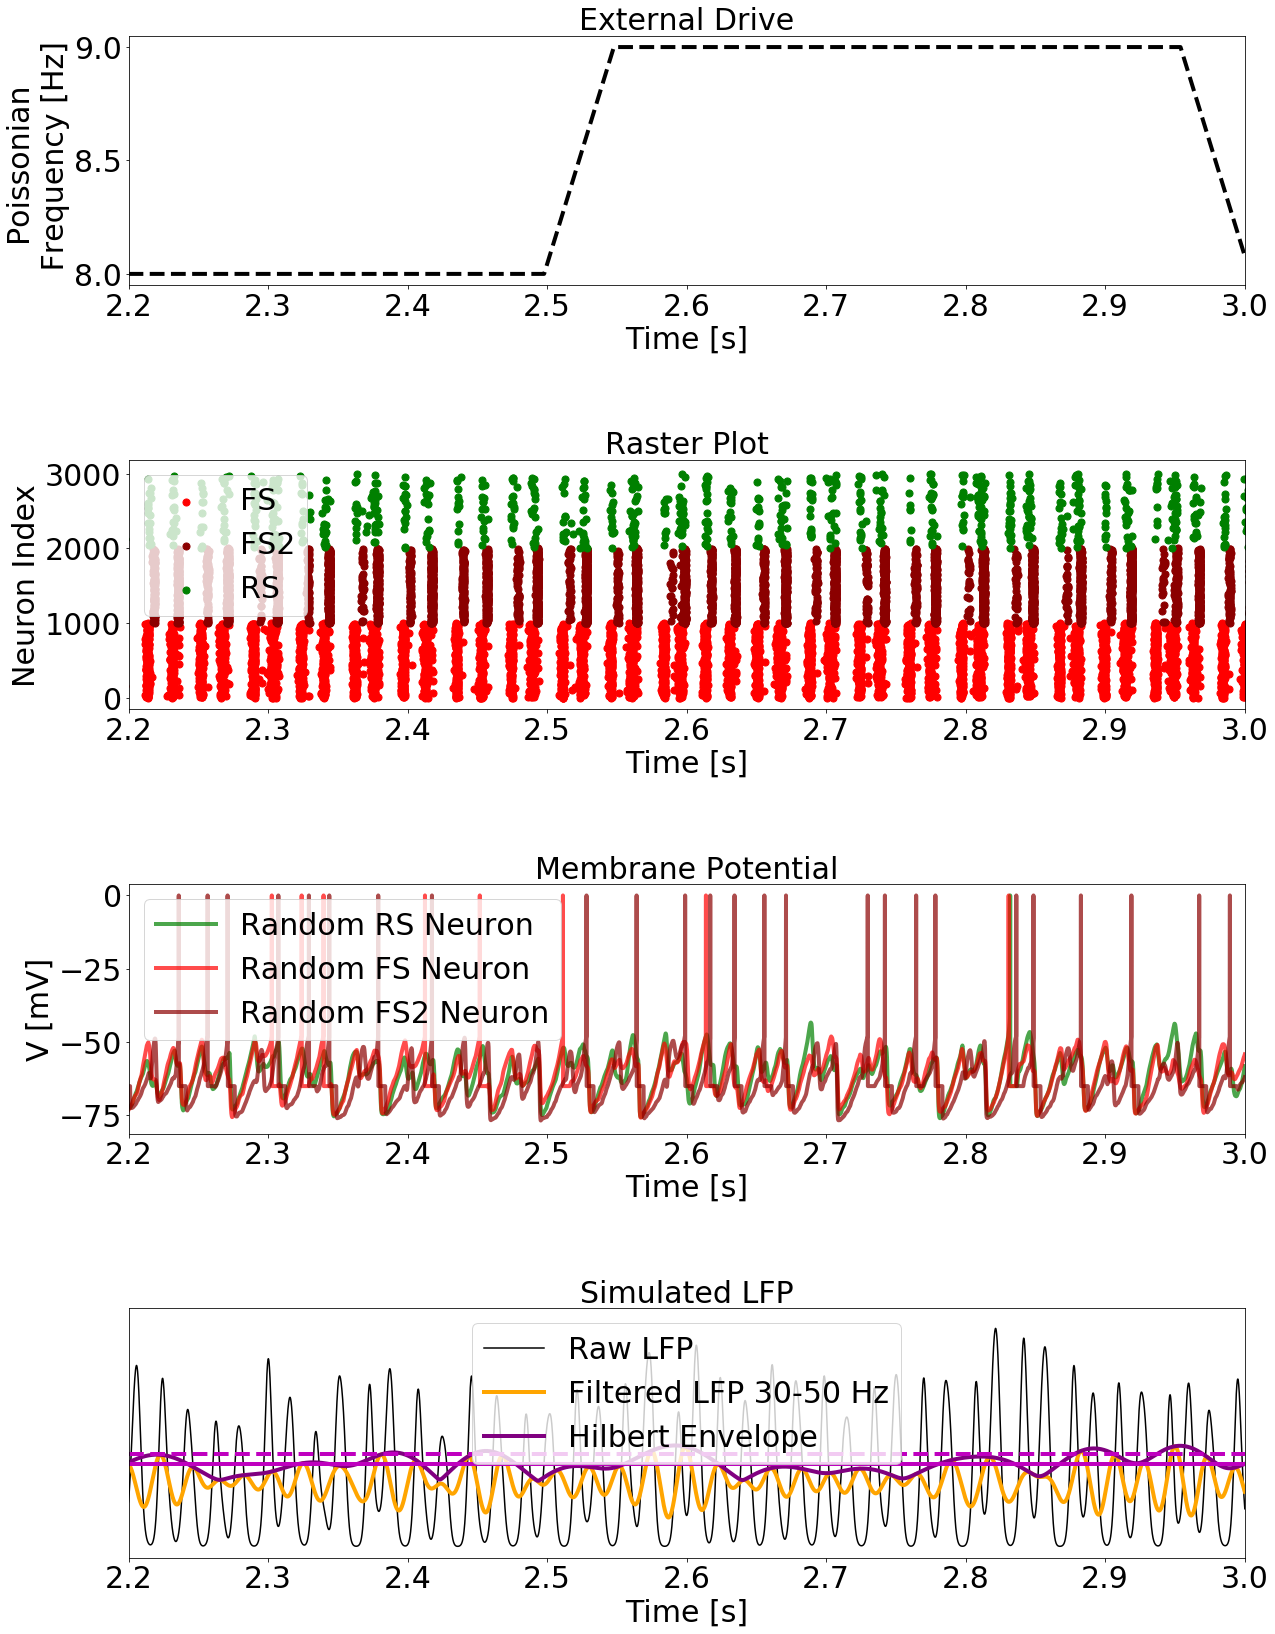

In [1]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.03 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.15  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5*nS #(FS2->FS)

Gee_r=1*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5.*ms; tauE_r= 5.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=8*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-10.png")
plt.show()





INFO       No numerical integration method specified for group 'neurongroup_4', using method 'euler' (took 0.01s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_5', using method 'euler' (took 0.01s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_6', using method 'euler' (took 0.01s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]


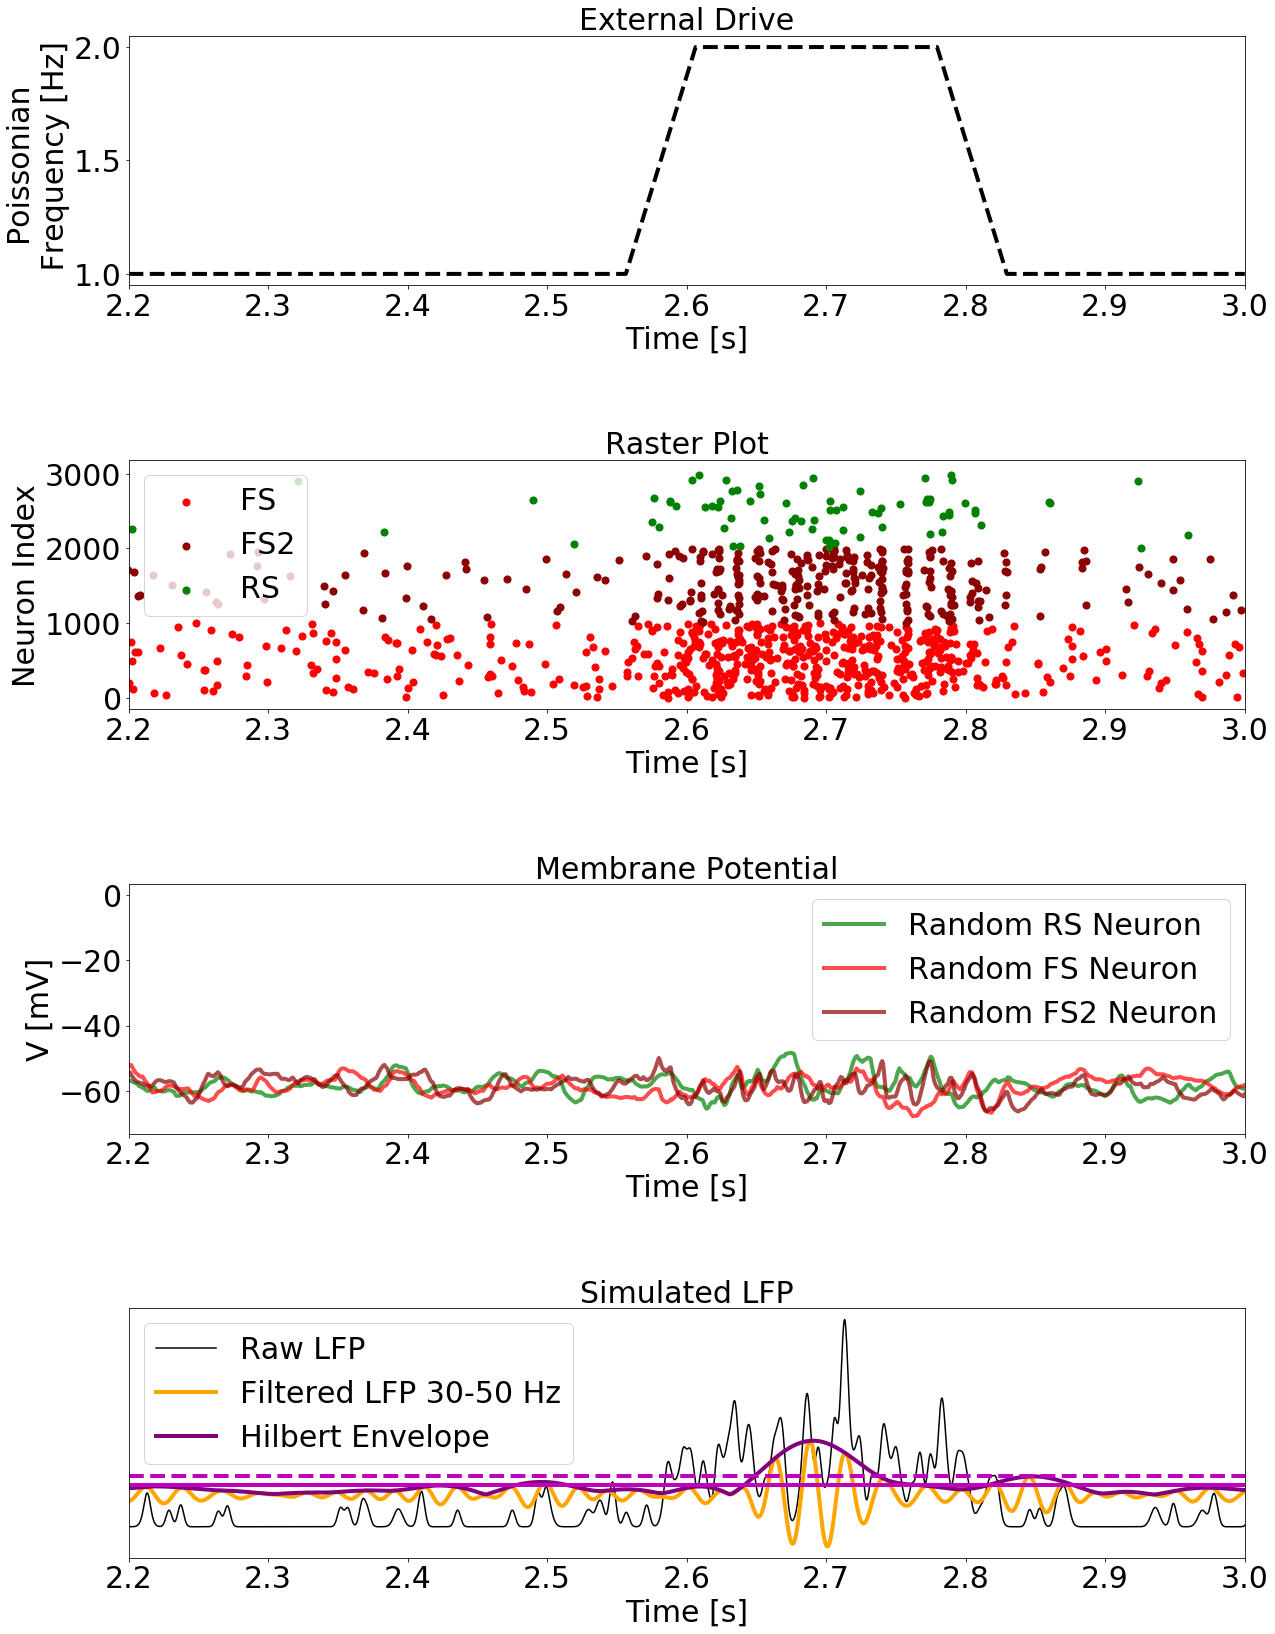

In [2]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.03 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.15  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5*nS #(FS2->FS)

Gee_r=1*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5.*ms; tauE_r= 5.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=1*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-11.png")
plt.show()





INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.12s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.01s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]


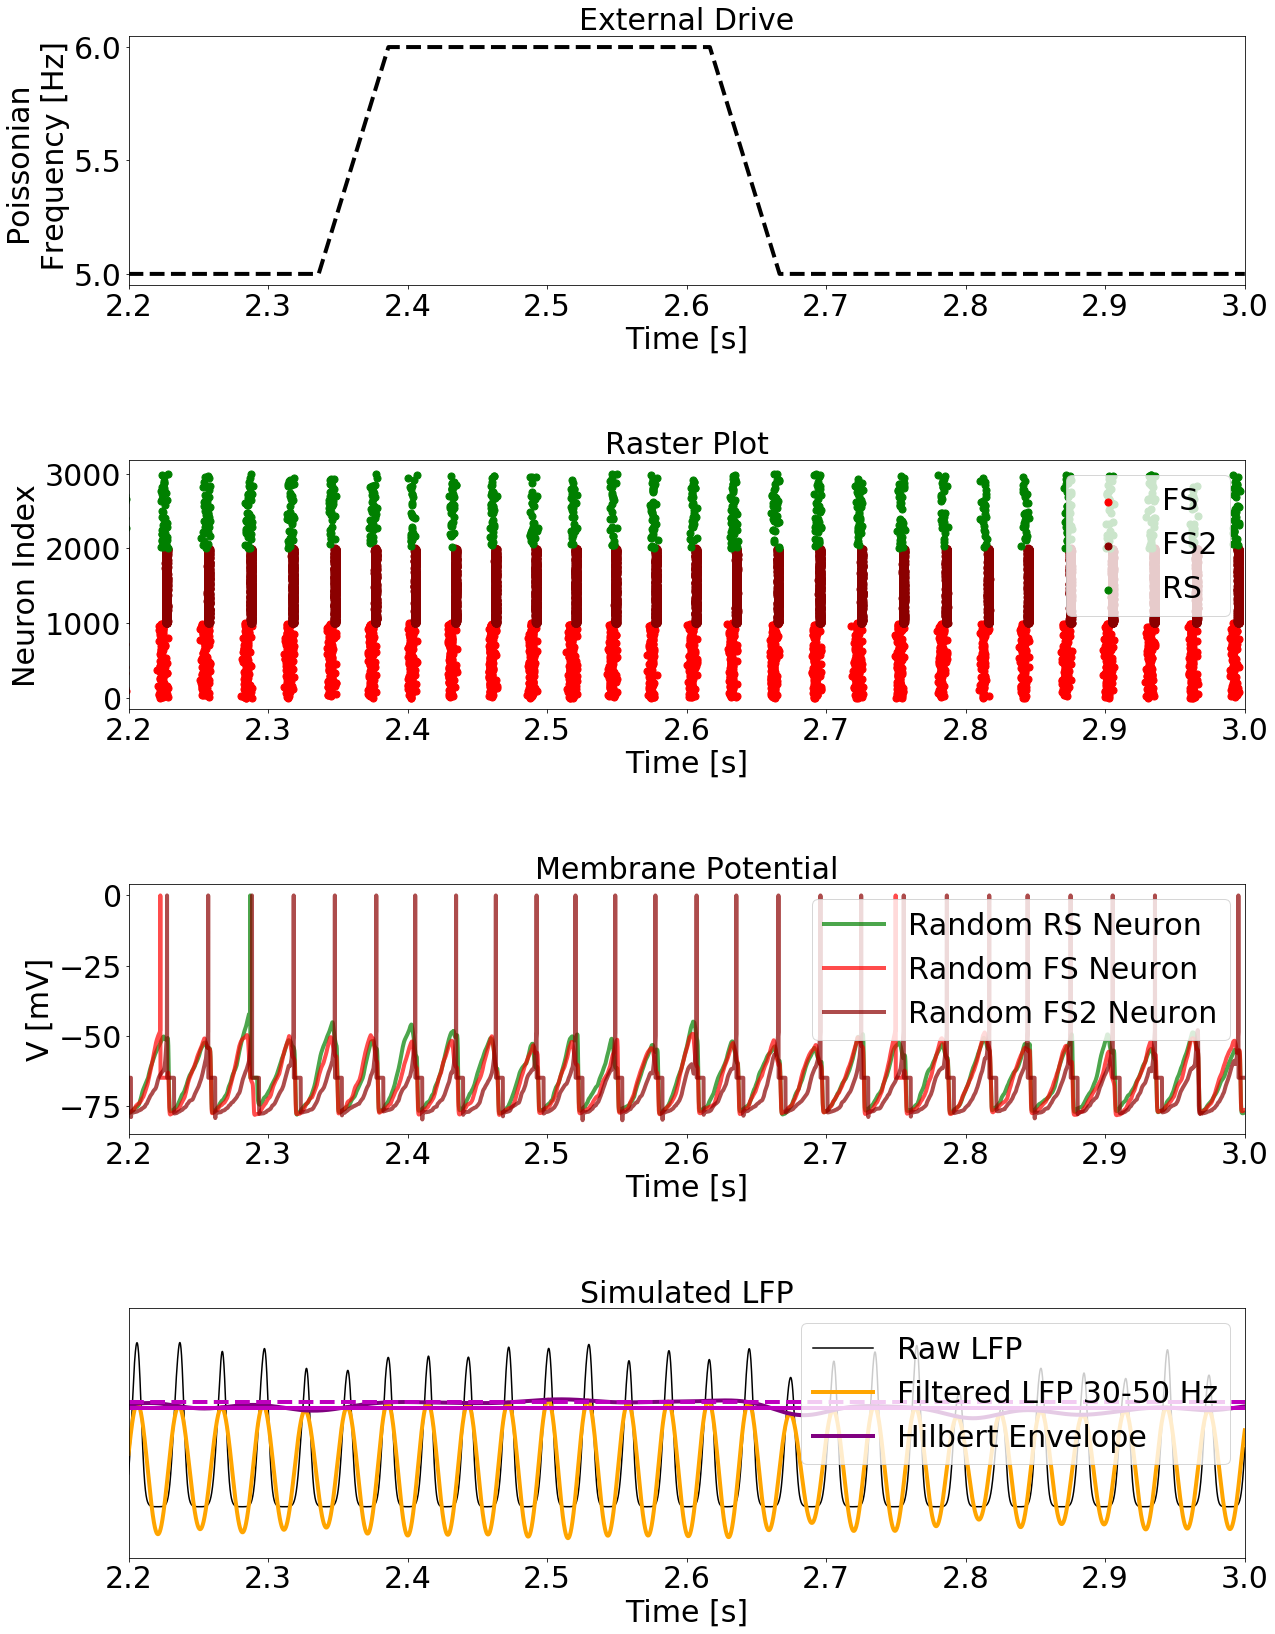

In [1]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.03 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.15  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5.5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5.5*nS #(FS2->FS)

Gee_r=1*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5.5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.5*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5.*ms; tauE_r= 5.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=5*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-12.png")
plt.show()





INFO       No numerical integration method specified for group 'neurongroup_4', using method 'euler' (took 0.01s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_5', using method 'euler' (took 0.01s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_6', using method 'euler' (took 0.01s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]


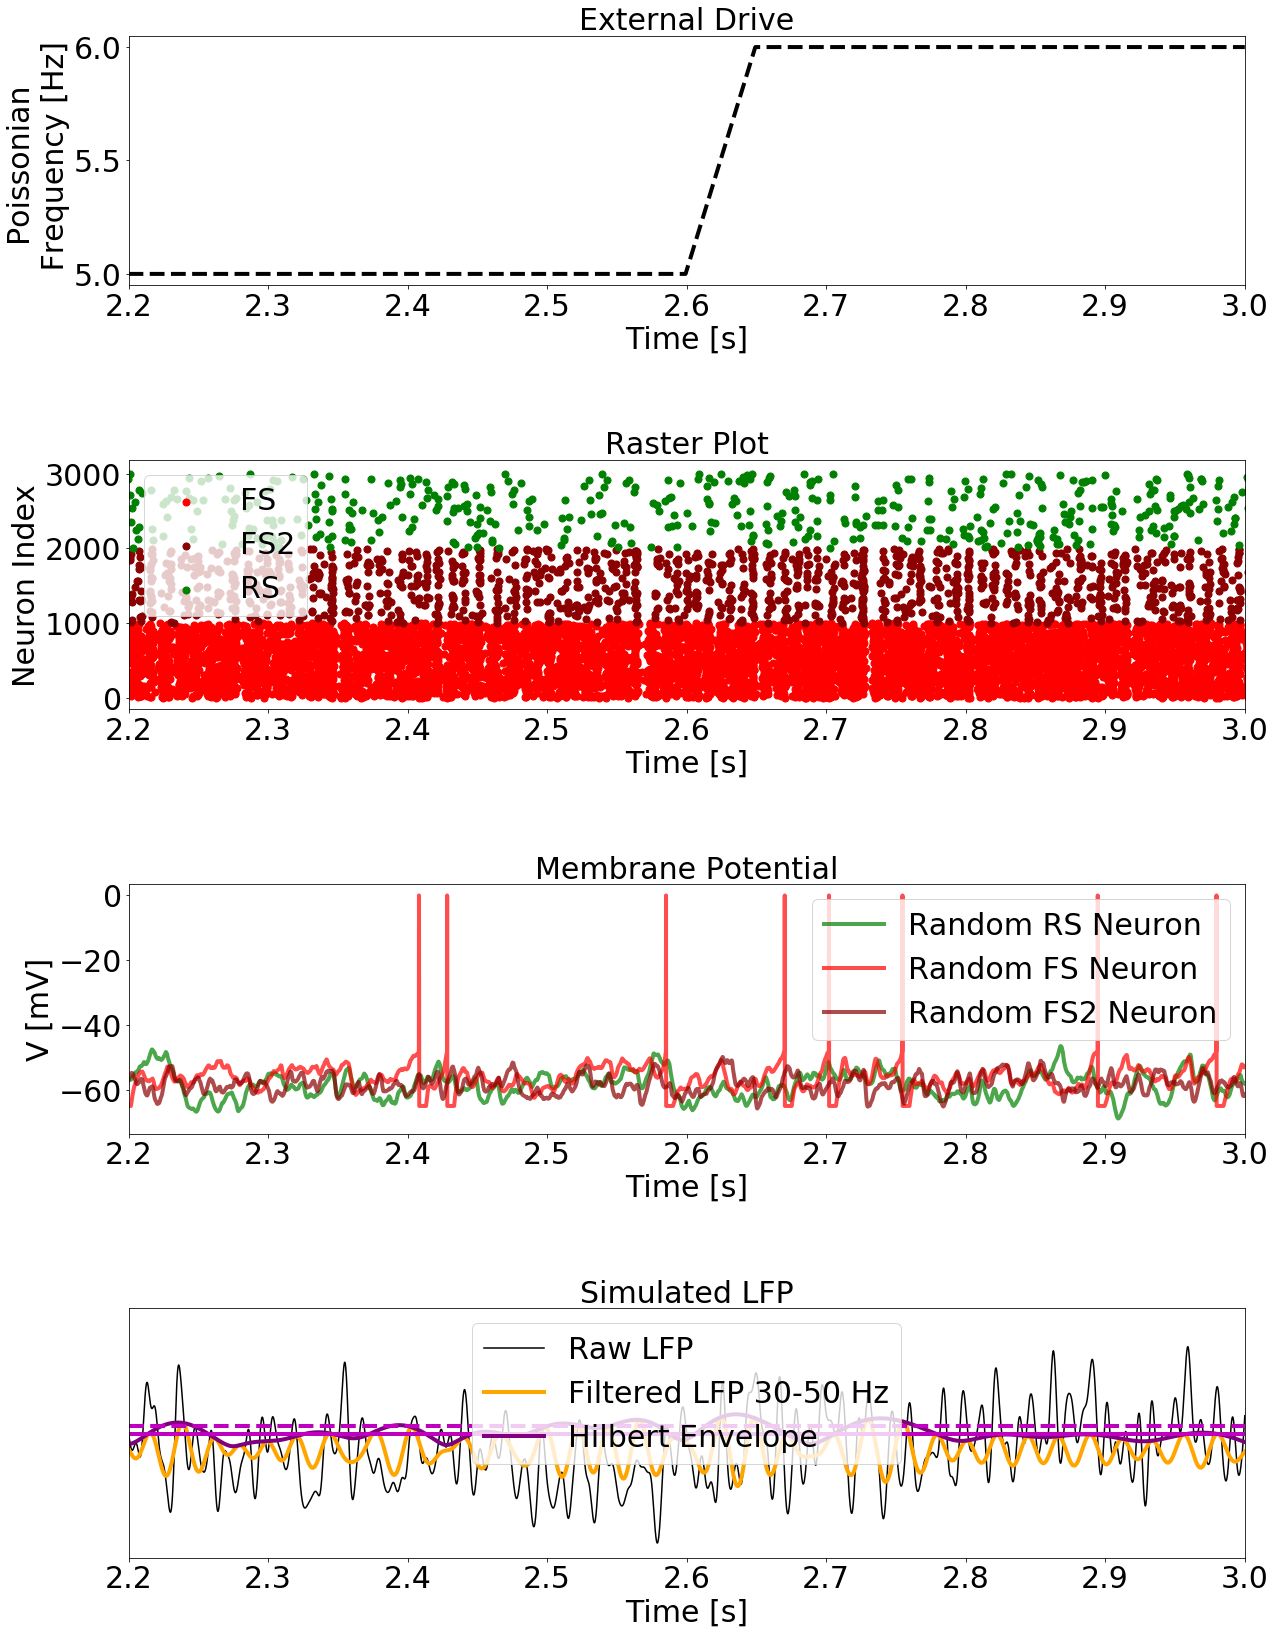

In [2]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.03 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.15  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=4*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=4*nS #(FS2->FS)

Gee_r=1*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=4*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=4.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5.*ms; tauE_r= 5.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=5*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-13.png")
plt.show()





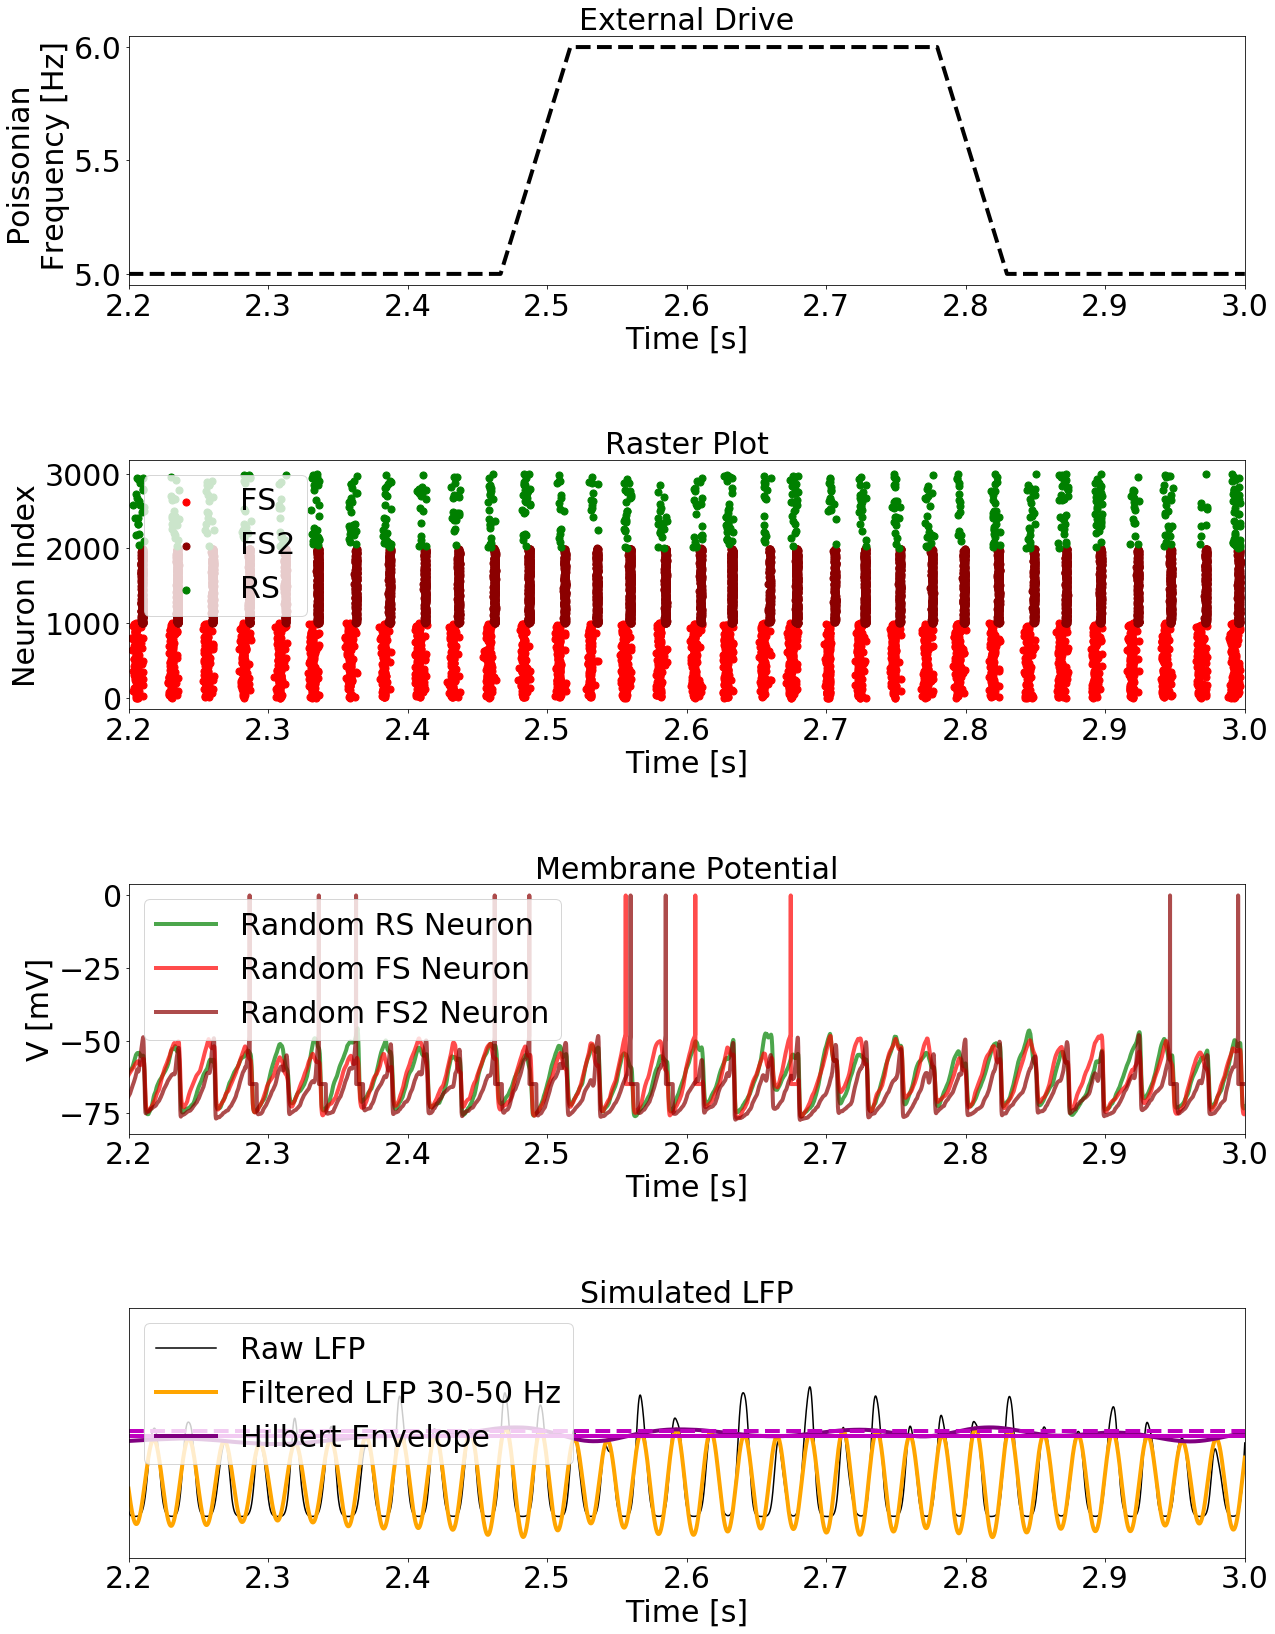

In [3]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.03 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.15  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5*nS #(FS2->FS)

Gee_r=1.3*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5.*ms; tauE_r= 5.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=5*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-14.png")
plt.show()





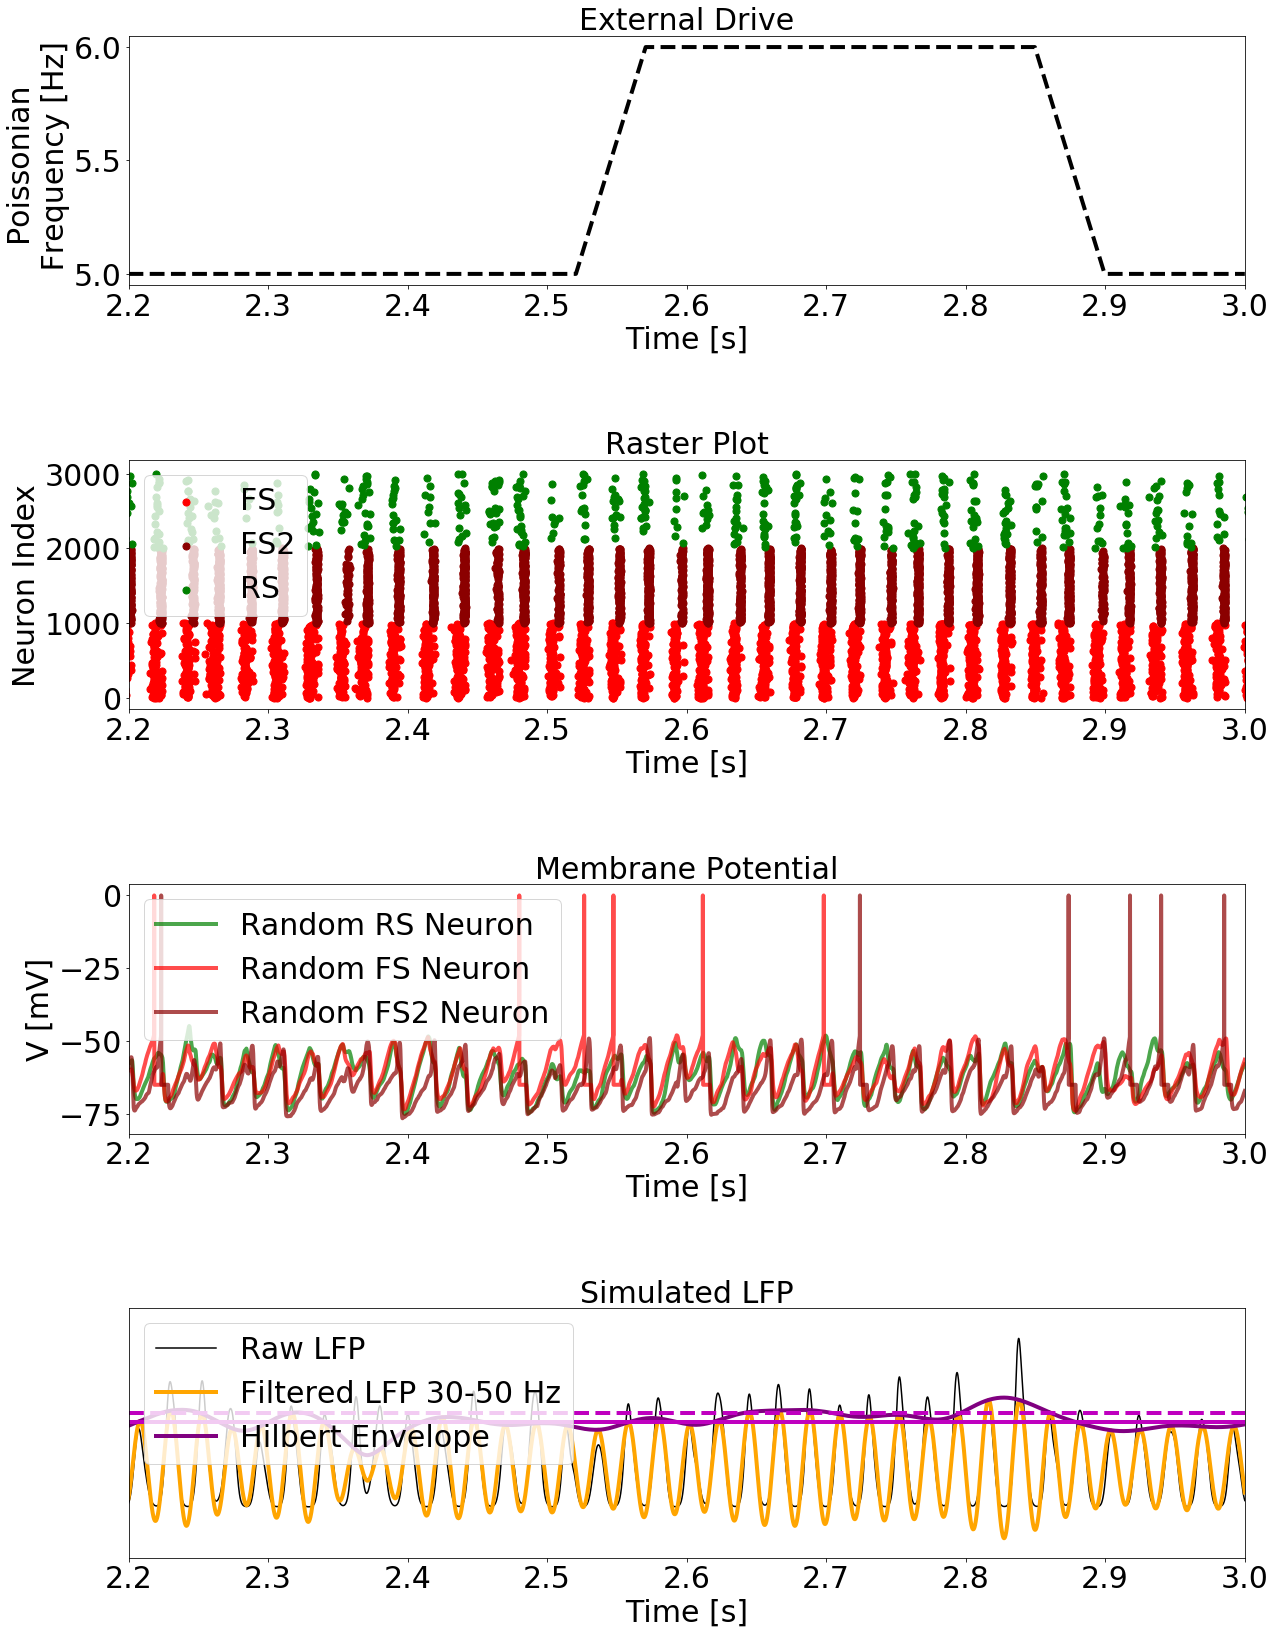

In [4]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.03 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.15  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5*nS #(FS2->FS)

Gee_r=0.9*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5.*ms; tauE_r= 5.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=5*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-15.png")
plt.show()





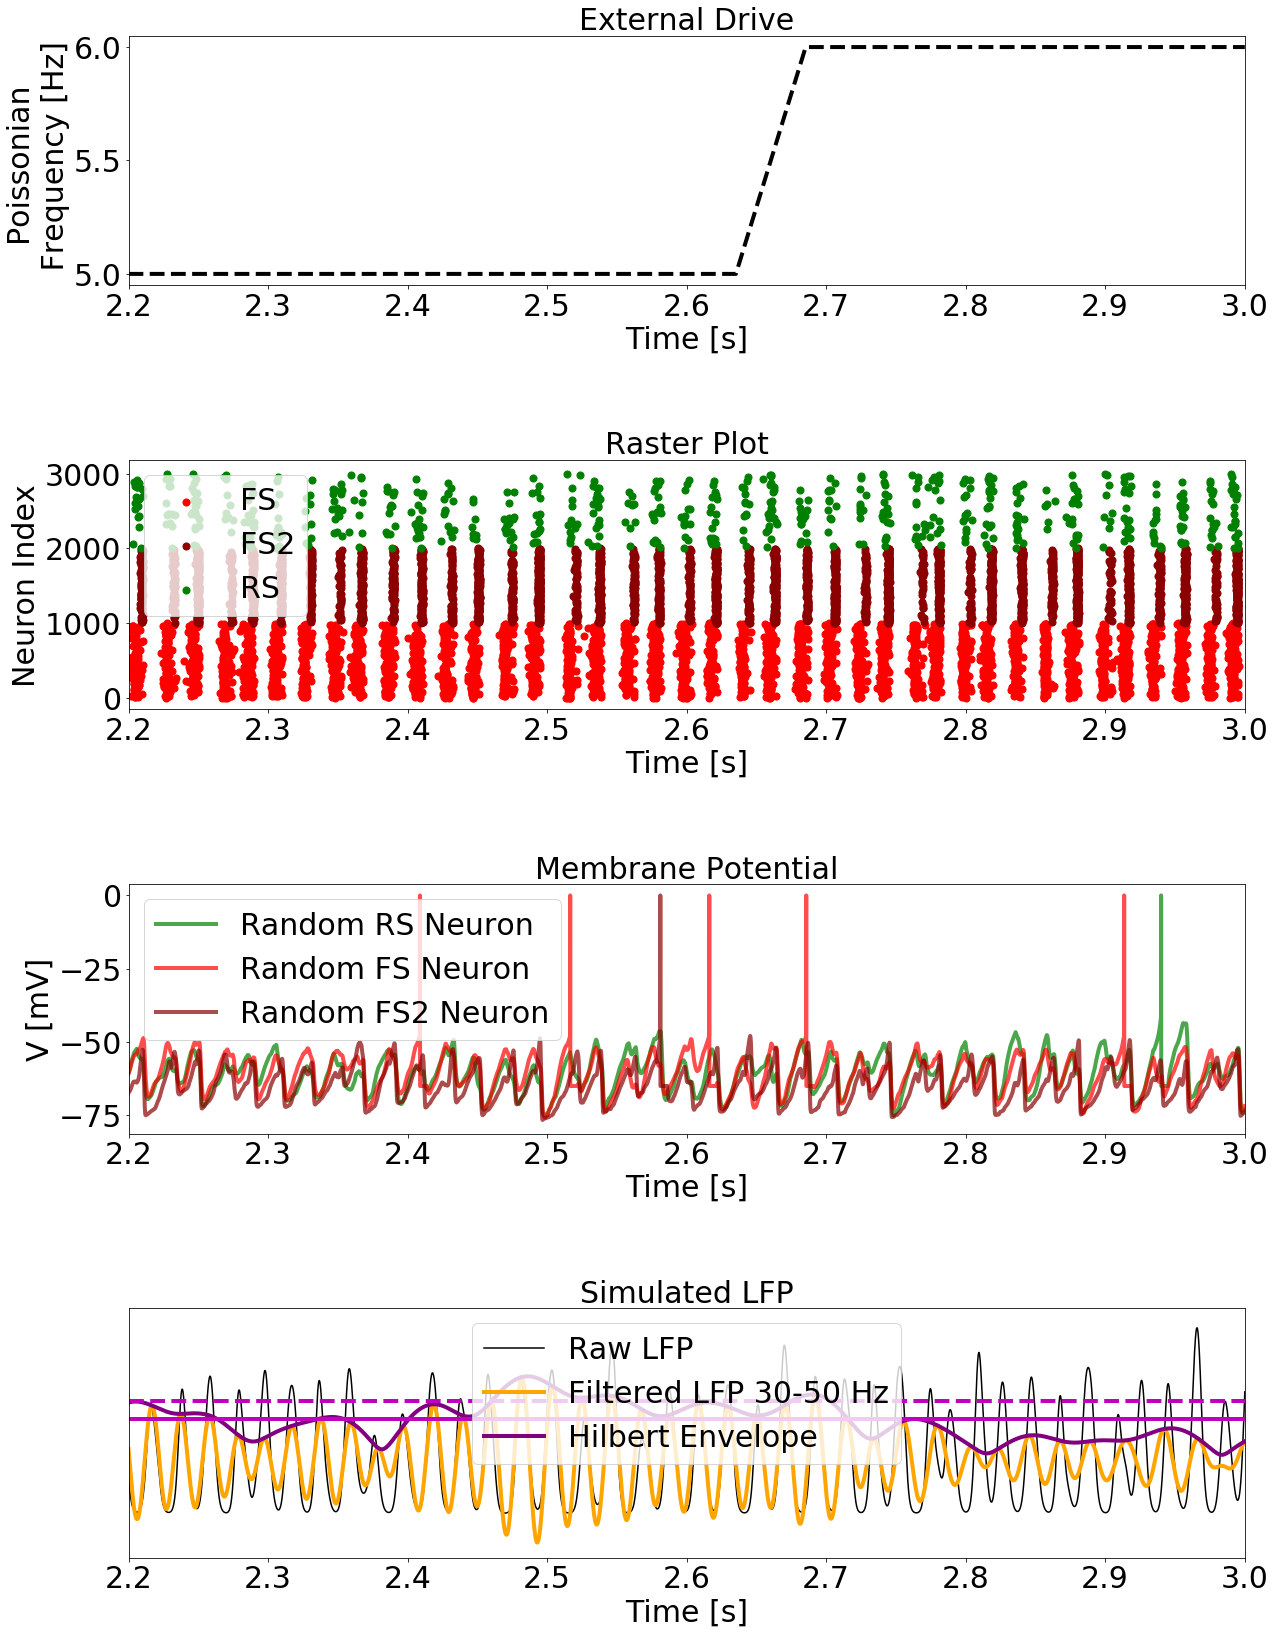

In [5]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.03 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.15  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5*nS #(FS2->FS)

Gee_r=1*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 6.*ms; tauE_r= 5.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=5*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-16.png")
plt.show()





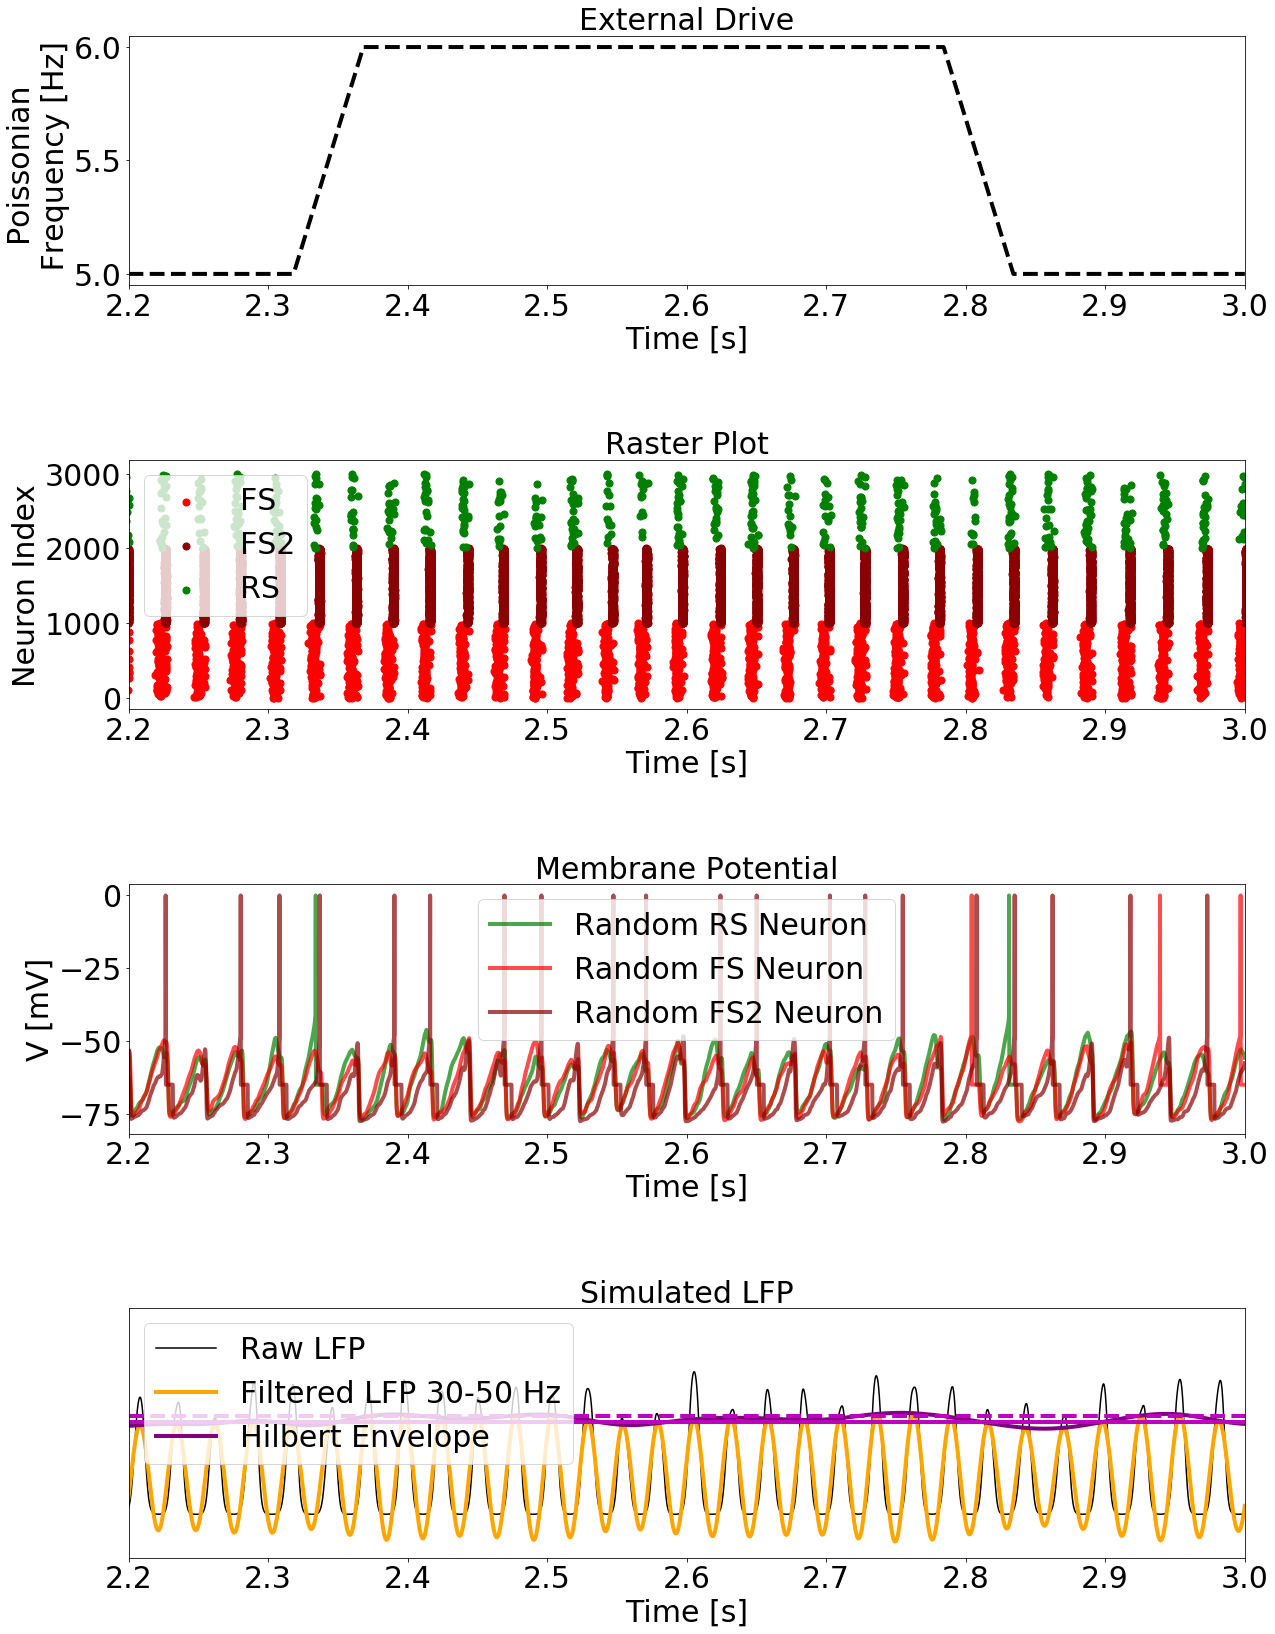

In [7]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.03 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.15  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5*nS #(FS2->FS)

Gee_r=1*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 4.*ms; tauE_r= 5.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=5*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-17.png")
plt.show()





INFO       No numerical integration method specified for group 'neurongroup_10', using method 'euler' (took 0.01s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_8', using method 'euler' (took 0.01s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_9', using method 'euler' (took 0.01s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]


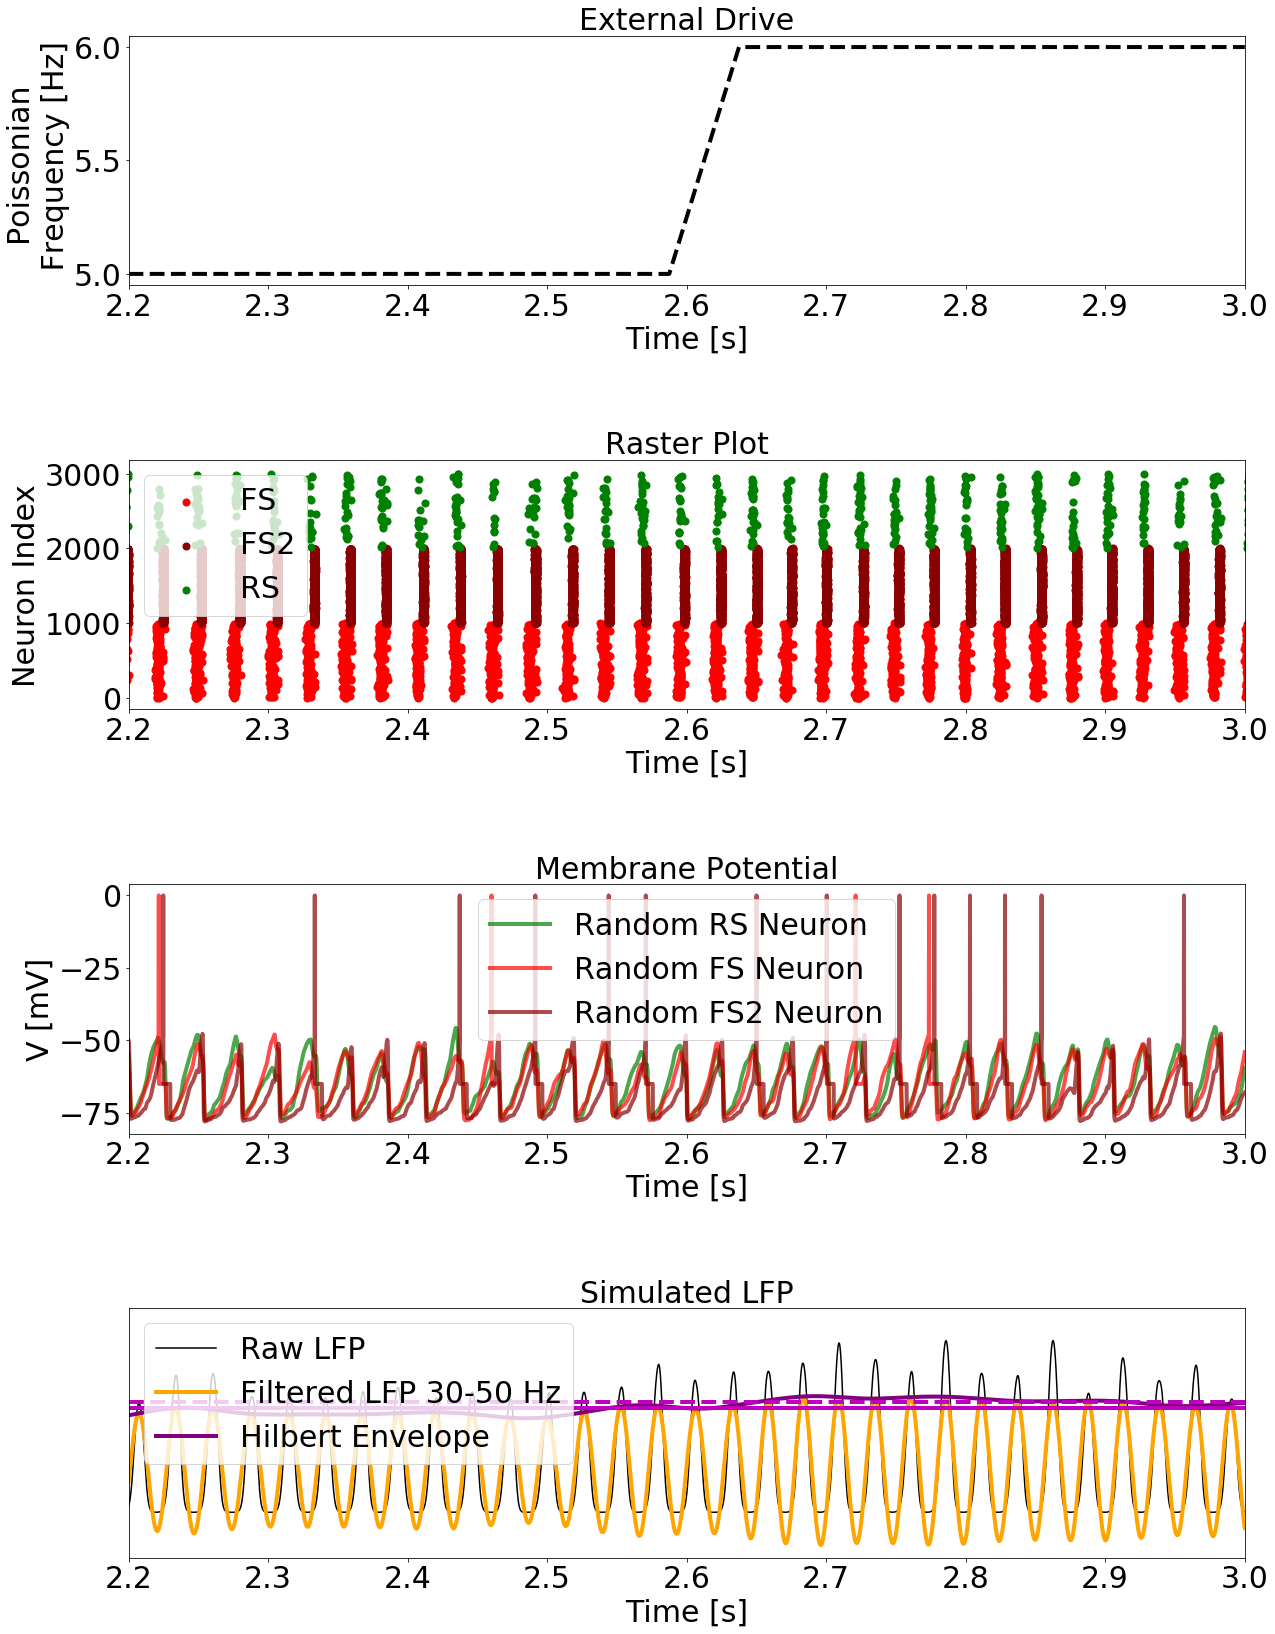

In [8]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.03 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.15  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5*nS #(FS2->FS)

Gee_r=1*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5.*ms; tauE_r= 6.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=5*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-18.png")
plt.show()





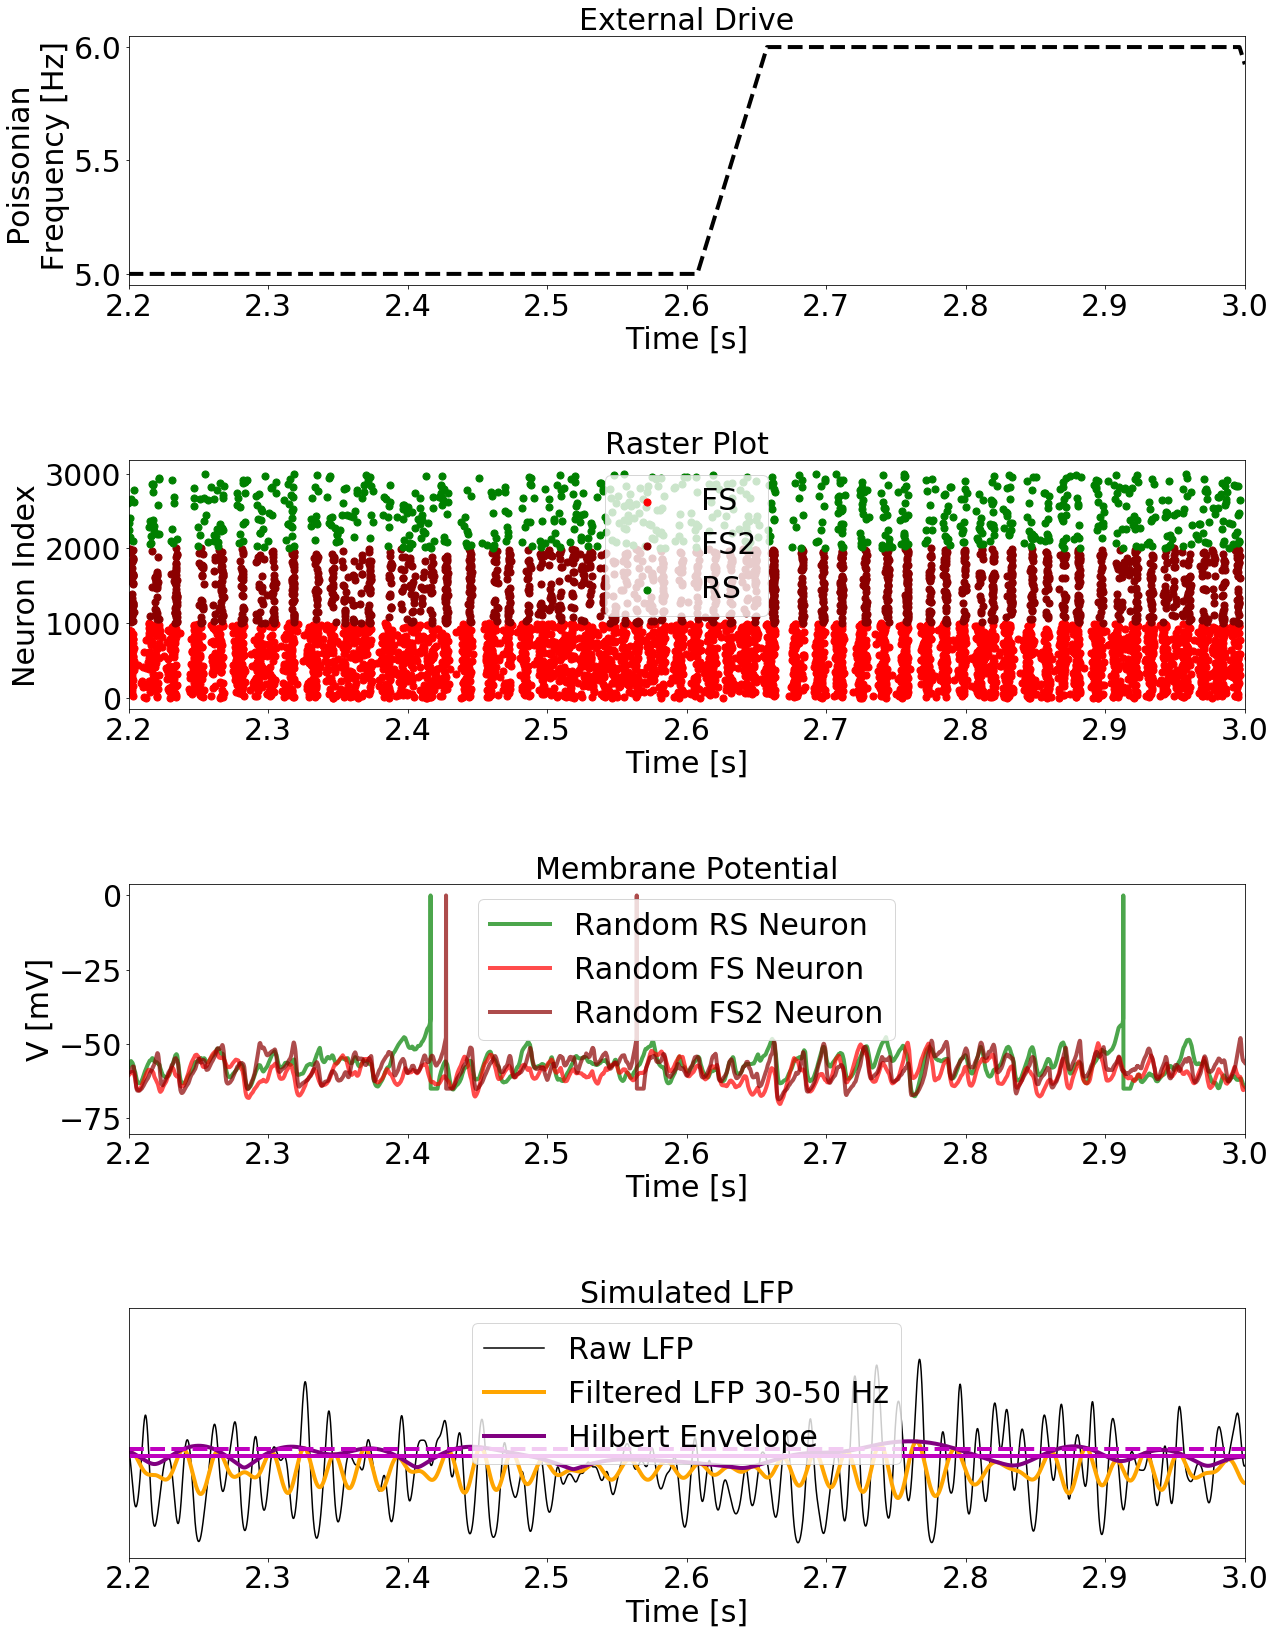

In [9]:
#========================================================================
from AuxiliarFunctions import *

#========================================================================
from brian2 import *
import numpy as np
from scipy import integrate
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import *
import random



"""
This code describes the implementation of the ING networkt developed in the following paper:

!!!!!!


If you use this code, please cite:
 


"""

#========================================================================

start_scope() # This is just to make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

t_simulation = 6*second

defaultclock.dt = 0.1*ms


################################################################################
#Network Structure
################################################################################

N=25000; Percentage=0.2

NE=int(N*4./5.); NI_total=int(N/5.)
NIosc=int(NI_total*Percentage); NI=NI_total-NIosc

#-----------------------------

prob_Pee=0.02 #(RS->RS)
prob_Pei=0.02 #(RS->FS)
prob_Peio=0.15#(RS->FS2)

prob_Pii=0.02 #(FS->FS)
prob_Pie=0.02 #(FS->RS)
prob_Piio=0.03 #(FS->FS2)

prob_Pioio=0.6 #(FS2->FS2)
prob_Pioe=0.15  #(FS2->RS) 
prob_Pioi=0.15  #(FS2->FS)

prob_p=0.02 #External


################################################################################
#Reescaling Synaptic Weights based on Synaptic Decay
################################################################################

tau_i= 5*ms; tau_e= 5*ms

#----------------------------
#References synaptic weights
Ge_extE_r=0.9*nS #(External in RS)
Ge_extI_r=0.9*nS #(External in FS)
Ge_extIosc_r=0.9*nS #(External in FS2)

Gioio_r=5*nS #(FS2->FS2)
Gioe_r=5*nS #(FS2->RS)
Gioi_r=5*nS #(FS2->FS)

Gee_r=1*nS  #(RS->RS)
Gei_r=1*nS  #(RS->FS)
Geio_r= 1*nS #(RS->FS2)

Gii_r=5*nS #(FS->FS)
Gie_r=5*nS #(FS->RS)
Giio_r=5.*nS #(FS->FS2)


#-----------------------------
#This allows to study the effect of the time scales alone

tauI_r= 5.*ms; tauE_r= 4.*ms #References time scales

Ge_extE=Ge_extE_r*tauE_r/tau_e 
Ge_extI=Ge_extI_r*tauE_r/tau_e
Gee=Gee_r*tauE_r/tau_e
Gei=Gei_r*tauE_r/tau_e

Gii=Gii_r*tauI_r/tau_i 
Gie=Gie_r*tauI_r/tau_i 

#Iosc

Ge_extIosc= Ge_extIosc_r*tauE_r/tau_e#(External in FS)
Geio= Geio_r*tauE_r/tau_e #(RS->FS2)

Giio=Giio_r*tauI_r/tau_i #(FS>FS2)
Gioio= Gioio_r*tauI_r/tau_i#(FS2->FS2)
Gioe= Gioe_r*tauI_r/tau_i#(FS2->RS)
Gioi= Gioi_r*tauI_r/tau_i#(FS2->FS)


################################################################################
#Neuron Model 
################################################################################

#######Parameters#######

V_reset=-65.*mvolt; VT=-50.*mV
Ei= -80.*mvolt; Ee=0.*mvolt; t_ref=5*ms
C = 150 * pF; gL = 10 * nS 

tauw=500*ms

Delay= 1.5*ms

#######Eleaky Heterogenities#######

Eleaky_FS2=np.full(NIosc,-65)*mV
Eleaky_RS=np.full(NE,-65)*mV
Eleaky_FS=np.full(NI,-65)*mV

########Equation#########

eqs= """
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + ge*(Ee-v)+ gi*(Ei-v) - w + I)/C : volt (unless refractory)
IsynE=ge*(Ee-v) : amp
IsynI=gi*(Ei-v) : amp
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
dw/dt = (a*(v - EL) - w)/tauw : amp
taum= C/gL : second
I : amp
a : siemens
b : amp
DeltaT: volt
Vcut: volt
EL : volt
"""


###### Initialize neuron group#############

#FS
neuronsI = NeuronGroup(NI, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsI.a=0*nS; neuronsI.b=0.*pA; neuronsI.DeltaT = 0.5*mV; neuronsI.Vcut = VT + 5*neuronsI.DeltaT
neuronsI.EL=Eleaky_FS

#FS2
neuronsIosc = NeuronGroup(NIosc, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)
neuronsIosc.a=0*nS; neuronsIosc.b=0.*pA; neuronsIosc.DeltaT = 0.5*mV; neuronsIosc.Vcut = VT + 5*neuronsIosc.DeltaT 
neuronsIosc.EL=Eleaky_FS2

#RS
neuronsE = NeuronGroup(NE, eqs, threshold='v>Vcut',reset="v=V_reset; w+=b", refractory=t_ref)#,method='rk2')
neuronsE.a=4*nS; neuronsE.b=20.*pA; neuronsE.DeltaT = 2.*mV; neuronsE.Vcut = VT + 5 *neuronsE.DeltaT
neuronsE.EL=Eleaky_RS

############################################################################################
#Initial condition
############################################################################################

#Random Membrane Potentials
neuronsI.v=np.random.uniform(low=-65,high=-50,size=NI)*mV
neuronsE.v=np.random.uniform(low=-65,high=-50,size=NE)*mV
neuronsIosc.v=np.random.uniform(low=-65,high=-50,size=NIosc)*mV

#Conductances
neuronsI.gi = 0.*nS;       neuronsI.ge = 0.*nS
neuronsE.gi = 0.*nS;       neuronsE.ge = 0.*nS
neuronsIosc.gi = 0.*nS;       neuronsIosc.ge = 0.*nS

#Adaptation Current
neuronsI.w = 0.*amp; neuronsE.w = 0.*amp; neuronsIosc.w = 0.*amp


############################################################################################
#External Stimulus
############################################################################################

#==========================================================================
#Correlated and Time Varying External Stimulus
#==========================================================================

f_min=0. ; f_max=1.

MinPlatoTime=150*(10**-3) ; MaxPlatoTime=600*(10**-3) 

TransitionTime=50*(10**-3) ; BaseTime=1 #all in seconds (no units)

T_simulation=t_simulation/second ; DT=defaultclock.dt/second

#-----


ExtFreqPattern_time, ExtFreqPattern=IrregularFluctuationPattern(f_min,f_max,TransitionTime,MinPlatoTime,MaxPlatoTime,BaseTime,DT,T_simulation)

rate_changes= TimedArray(ExtFreqPattern*Hz, dt=defaultclock.dt)

#-----

ExternalStimulus=NeuronGroup(NE, 'rates = rate_changes(t) : Hz',threshold='rand() < rates * dt')

#==========================================================================
#Independent External Stimulus (constant)
#==========================================================================

ExtFreq=5*Hz ; N_ext=int(NE*prob_p)


PoissonEonI= PoissonInput(neuronsI, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extI)

PoissonEonIosc= PoissonInput(neuronsIosc, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extIosc)

PoissonEonE = PoissonInput(neuronsE, 'ge', N=N_ext, rate=ExtFreq, weight=Ge_extE)

#==========================================================================
#External Current
#==========================================================================

neuronsI.I = 0.*namp
neuronsIosc.I = 0.*namp
neuronsE.I = 0.*namp

##########################################################################################
#Synaptic Connections
############################################################################################

#===========================================
#Gamma Network
#===========================================


con_ioio = Synapses(neuronsIosc, neuronsIosc, on_pre='gi_post += Gioio', delay=Delay)
con_ioio.connect(p=prob_Pioio)


#===========================================
#FS1a-RS Network (AI Network)
#===========================================

con_ee = Synapses(neuronsE, neuronsE, on_pre='ge_post += Gee', delay=Delay)
con_ee.connect(p=prob_Pee)


con_ii = Synapses(neuronsI, neuronsI, on_pre='gi_post += Gii', delay=Delay)
con_ii.connect(p=prob_Pii)
   
  
con_ie = Synapses(neuronsI, neuronsE, on_pre='gi_post += Gie', delay=Delay)
con_ie.connect(p=prob_Pie)
 

con_ei = Synapses(neuronsE, neuronsI, on_pre='ge_post += Gei', delay=Delay)
con_ei.connect(p=prob_Pei)


#===========================================
#Connections between Iosc and RS.
#===========================================

con_ioe = Synapses(neuronsIosc, neuronsE, on_pre='gi_post += Gioe', delay=Delay)
con_ioe.connect(p=prob_Pioe)

#===========================================
#---Connections between RS and Iosc (Feedback)
#===========================================

con_eio = Synapses(neuronsE, neuronsIosc,on_pre='ge_post += Geio', delay=Delay)
con_eio.connect(p=prob_Peio)

#===========================================
#---Connections between Iosc and FS1
#===========================================

con_ioi = Synapses(neuronsIosc, neuronsI,on_pre='gi_post += Gioi', delay=Delay)
con_ioi.connect(p=prob_Pioi)

#===========================================
#---Connections between FS1 and Iosc
#===========================================

con_iio = Synapses(neuronsI, neuronsIosc,on_pre='gi_post += Giio', delay=Delay)
con_iio.connect(p=prob_Piio)

#===========================================
#Time dependent External Input
#===========================================

con_ExtStN_Iosc=Synapses(ExternalStimulus, neuronsIosc, on_pre='ge_post += Ge_extIosc', delay=0.*ms)
con_ExtStN_Iosc.connect(p=prob_p)

con_ExtStN_E=Synapses(ExternalStimulus, neuronsE, on_pre='ge_post += Ge_extE', delay=0.*ms)
con_ExtStN_E.connect(p=prob_p)
    
con_ExtStN_I=Synapses(ExternalStimulus, neuronsI, on_pre='ge_post += Ge_extI', delay=0.*ms)
con_ExtStN_I.connect(p=prob_p)



########################################################################################
# Simulation
########################################################################################


#FS
statemonI = StateMonitor(neuronsI, ['v'], record=[0])
spikemonI = SpikeMonitor(neuronsI, variables='t') 

#FS2
statemonIosc = StateMonitor(neuronsIosc, ['v'], record=[0])
spikemonIosc = SpikeMonitor(neuronsIosc, variables='t') 

#RS
statemonE = StateMonitor(neuronsE, ['v'], record=[0])
spikemonE = SpikeMonitor(neuronsE, variables='t') 

run(t_simulation)


####################################################################################################
#Organizing Neuronal Spikes (for LFP Calculation)
####################################################################################################

starting_time=1000 #ms -> WARNING: Everything should be in ms
ending_time=t_simulation/ms 
duration=ending_time-starting_time


NeuronIDE=np.array(spikemonE.i)
NeuronIDI=np.array(spikemonI.i)
NeuronIDIosc=np.array(spikemonIosc.i)

timeE=np.array(spikemonE.t/ms) #time in ms
timeI=np.array(spikemonI.t/ms)
timeIosc=np.array(spikemonIosc.t/ms)

#Taking only a subgroups of neurons

Nsub=1000
NEsub=int(Nsub*4./5.); NI_totalsub=int(Nsub/5.)
Percentage=0.2; NIoscsub=int(NI_totalsub*Percentage); NIsub=NI_totalsub-NIoscsub

NeuronIDEsub=NeuronIDE[NeuronIDE<NEsub]
NeuronIDIsub=NeuronIDI[NeuronIDI<NIsub]+NEsub #---> this +NEsub is important for the code bellow
NeuronIDIoscsub=NeuronIDIosc[NeuronIDIosc<NIoscsub]+NEsub+NIsub

timeEsub=timeE[NeuronIDE<NEsub]
timeIsub=timeI[NeuronIDI<NIsub]
timeIoscsub=timeIosc[NeuronIDIosc<NIoscsub]

#Cutting Transient Part:

NeuronID_E=NeuronIDEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]
time_E=timeEsub[((timeEsub>=starting_time) & (timeEsub<ending_time))]

NeuronID_I=NeuronIDIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]
time_I=timeIsub[((timeIsub>=starting_time) & (timeIsub<ending_time))]

NeuronID_Iosc=NeuronIDIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]
time_Iosc=timeIoscsub[((timeIoscsub>=starting_time) & (timeIoscsub<ending_time))]

##################################################################
# Distributing cells in a 2D grid:
##################################################################

xmax = 0.2  # size of the array (in mm)
ymax = 0.2

X, Y = np.random.rand(2, Nsub) * np.array([[xmax, ymax]]).T

#0 to NEsub-1: RS
#NEsub to NEsub+NIsub-1: FS1


####################################################################################################
#LFP Parameters
####################################################################################################


# Table of respective amplitudes:
# Layer   amp_i    amp_e
# deep    -2       -1.6
# soma    30       4.8
# sup     -12      2.4
# surf    3        -0.8
#


#----------------------------------------------
"""
These parameters were taken from the article:
Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field
potentials from networks of spiking neurons
Journal of Neuroscience Methods
"""
#----------------------------------------------



time_resolution = 0.1  # time resolution
npts = int(duration / time_resolution)  # nb points in LFP vector

xe = xmax / 2
ye = ymax / 2  # coordinates of electrode

va = 200  # axonal velocity (mm/sec)
lambda_ = 0.2  # space constant (mm)
dur = 100  # total duration of LFP waveform
nlfp = int(dur / time_resolution)  # nb of LFP pts
amp_e = 0.7  # uLFP amplitude for exc cells
amp_i = -3.4  # uLFP amplitude for inh cells
sig_i = 2.1  # std-dev of ihibition (in ms)
sig_e = 1.5 * sig_i  # std-dev for excitation

# amp_e = -0.16	# exc uLFP amplitude (deep layer)
# amp_i = -0.2	# inh uLFP amplitude (deep layer)

amp_e = 0.48  # exc uLFP amplitude (soma layer)
amp_i = 3  # inh uLFP amplitude (soma layer)

# amp_e = 0.24	# exc uLFP amplitude (superficial layer)
# amp_i = -1.2	# inh uLFP amplitude (superficial layer)

# amp_e = -0.08	# exc uLFP amplitude (surface)
# amp_i = 0.3	# inh uLFP amplitude (surface)

dist = np.sqrt((X - xe) ** 2 + (Y - ye) ** 2)  # distance to  electrode in mm
delay = 10.4 + dist / va  # delay to peak (in ms)
amp = np.exp(-dist / lambda_)
amp[:NE] *= amp_e
amp[NE:] *= amp_i

s_e = 2 * sig_e * sig_e
s_i = 2 * sig_i * sig_i


Time_LFP= (np.arange(npts) * time_resolution) + starting_time #in ms



####################################################################################################
#LFP Calculation Functions
####################################################################################################

"""
This code was taken from the article: Telenczuk B, Telenczuk M, Destexhe A (2020)
A kernel-based method to calculate local field potentials from networks of spiking neurons
Journal of Neuroscience Methods

The code is originaly available at: 
https://senselab.med.yale.edu/ModelDB/showmodel.cshtml?model=266508&file=%2fdemo_kernel%2fdemo_lfp_kernel.py#tabs-2

"""


#=======================================

def f_temporal_kernel(t, tau):
    """function defining temporal part of the kernel"""
    return np.exp(-(t ** 2) / tau)


#=======================================
def calc_lfp(cells_time,cells_id,tau):
    """Calculate LFP from cells"""

    # this is a vectorised computation and as such it might be memory hungry
    # for long LFP series/large number of cells it may be more efficient to calculate it through looping

    spt = cells_time
    cid = cells_id
    
    kernel_contribs = amp[None, cid] * f_temporal_kernel(
        Time_LFP[:, None] - delay[None, cid] - spt[None, :], tau
    )
    lfp = kernel_contribs.sum(1)
    return lfp


####################################################################################################
#LFP Calculation
####################################################################################################


lfp_E = calc_lfp(time_E,NeuronID_E,s_e)
lfp_I = calc_lfp(time_I,NeuronID_I,s_i)
lfp_Iosc = calc_lfp(time_Iosc,NeuronID_Iosc,s_i)

LFP = lfp_E + lfp_I + lfp_Iosc


####################################################################################
#Oscilation Phase (By Hilbert Transform)
####################################################################################

zLFP=ZscoreNorm(LFP)

FreqBand=40 #Hz

lowcut_main=FreqBand-10 ; highcut_main=FreqBand+10 #Hz #Warning: if the bondaries are not well-chosen the result is bad

Phase_time,LFPFiltered_main,LFP_thatOverLapsFileteredOne,Envelope_main,Oscillation_Phase_main=SignalPhase_byHilbert(zLFP, Time_LFP/1000., lowcut_main, highcut_main,time_resolution*(10**-3)) #Phase from -pi to pi -> pick apears approx at 0 

####################################################################################
#Figure Output
####################################################################################

#---------------------------------------------
#Adding spike picks to membrane potential:
#---------------------------------------------

Membrane_time=statemonI[0].t/second
Membrane_I=statemonI[0].v/mV; Membrane_Iosc=statemonIosc[0].v/mV; Membrane_E=statemonE[0].v/mV

#---Spike Times per Neuron----

SpikeTimesE = spikemonE.all_values()
SpikeTimesI = spikemonI.all_values()
SpikeTimesIosc = spikemonIosc.all_values()

#-------------------------------------

v_nicerI=Membrane_I
for T in SpikeTimesI['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerI[k] = 0 #mV

v_nicerIosc=Membrane_Iosc
for T in SpikeTimesIosc['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerIosc[k] = 0 #mV    

v_nicerE=Membrane_E
for T in SpikeTimesE['t'][0]:
    k = int(T/defaultclock.dt)
    v_nicerE[k] = 0 #mV    


#---------------------------------------------
#Plotting:
#---------------------------------------------
    
Fig=plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 


figa=Fig.add_subplot(411)
plt.title('External Drive', fontsize=30)
plt.plot(ExtFreqPattern_time, ExtFreqPattern+ExtFreq/Hz,ls='--',color='k', linewidth=4)
plt.ylabel('Poissonian \n Frequency [Hz]', fontsize=30)    
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)


figa=Fig.add_subplot(412)
len_set=1000
plt.title('Raster Plot', fontsize=30)
plt.scatter(spikemonI.t[spikemonI.i<len_set]/second, spikemonI.i[spikemonI.i<len_set], color='red',s=50,label="FS")
plt.scatter(spikemonIosc.t[spikemonIosc.i<len_set]/second, spikemonIosc.i[spikemonIosc.i<len_set]+ len_set, color='darkred',s=50,label="FS2")
plt.scatter(spikemonE.t[spikemonE.i<len_set]/second, spikemonE.i[spikemonE.i<len_set] + 2*len_set, color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Neuron Index', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(413)
plt.title('Membrane Potential', fontsize=30)
plt.plot(Membrane_time,v_nicerE,color='green', linewidth=4,alpha=0.7,label='Random RS Neuron')
plt.plot(Membrane_time,v_nicerI,color='red', linewidth=4,alpha=0.7,label='Random FS Neuron')
plt.plot(Membrane_time,v_nicerIosc,color='darkred', linewidth=4,alpha=0.7,label='Random FS2 Neuron')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('V [mV]', fontsize=30)
plt.xlim(2.2,3)

figa=Fig.add_subplot(414)
plt.title('Simulated LFP', fontsize=30)
plt.plot(Phase_time,LFP_thatOverLapsFileteredOne,color='k',label='Raw LFP')
plt.plot(Phase_time,LFPFiltered_main,linewidth=4,color='orange',label="Filtered LFP "+str(int(lowcut_main))+"-"+str(int(highcut_main))+" Hz")
plt.plot(Phase_time,Envelope_main,linewidth=4,color='purple',label="Hilbert Envelope")

plt.axhline(y=mean(Envelope_main),linestyle='-',linewidth=4, color='m')#,label=r'Mean Envelope ($\mu$)')
plt.axhline(y=mean(Envelope_main)+np.std(Envelope_main),linestyle='--',linewidth=4, color='m')#,label=r'$\mu$+$\sigma$')
plt.legend(loc='best', fontsize=30)
plt.xlabel('Time [s]', fontsize=30)
plt.xlim(2.2,3)
figa.set_yticks([])
#plt.tight_layout()
plt.savefig("RS-FS-FS2-19.png")
plt.show()



